# 🧠 Pipeline Complet Wide+Deep FIXED - Classification ECG PTB-XL

---

## 📋 Informations

| Métrique | Valeur |
|----------|--------|
| **Modèle Final** | `model_wide_deep_pure_FIXED.pth` |
| **Performance** | **91.98% AUC Macro** |
| **Dataset** | PTB-XL (21,481 ECG) |
| **Classes** | NORM, MI, STTC, CD, HYP |
| **Architecture** | Wide+Deep (11.5M params) |

---

## 📑 Table des Matières

1. **Configuration & Imports**
2. **STEP 0: Prétraitement Initial (CSV → Features)**
3. **STEP 1: Chargement depuis Excel**
4. **STEP 2: Nettoyage des Signaux ECG**
5. **STEP 3: Extraction Features Wide (NeuroKit2)**
6. **STEP 4: Préparation Features Wide**
7. **STEP 5: Architecture Wide+Deep**
8. **STEP 6: Entraînement FIXED** ⭐
9. **STEP 7: Évaluation & Courbes ROC**
10. **Utilisation du Modèle**

---

---

# 📊 PARTIE EDA: Analyse Exploratoire Complète

Cette section intègre l'analyse exploratoire complète du dataset PTB-XL.

## Structure de l'EDA

| Partie | Contenu | Graphiques |
|--------|---------|------------|
| **A - EDA Générale** | Démographie, Diagnostics, Temporel, Qualité | EDA_01 à EDA_04 |
| **B - Dépendances** | Âge, Sexe, Anthropométrie vs Codes SCP | Dependances_01 à 06 |
| **C - Corrélations** | Features vs Maladies, Matrice brute | Correlation_* |

---

In [30]:
"""
═══════════════════════════════════════════════════════════════════════════════
                   ANALYSE EXPLORATOIRE COMPLÈTE - PTB-XL ECG Database
                            Script Unifié EDA - Version Notebook
═══════════════════════════════════════════════════════════════════════════════
"""

# ===== Imports EDA =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import ast
from collections import Counter
from datetime import datetime
from scipy import stats
from scipy.stats import chi2_contingency, mannwhitneyu, kruskal

# ===== Configuration EDA =====
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# Configuration des figures
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

print("═" * 100)
print("              ANALYSE EXPLORATOIRE COMPLÈTE - PTB-XL ECG Database")
print("═" * 100)

════════════════════════════════════════════════════════════════════════════════════════════════════
              ANALYSE EXPLORATOIRE COMPLÈTE - PTB-XL ECG Database
════════════════════════════════════════════════════════════════════════════════════════════════════


In [31]:
# ═══════════════════════════════════════════════════════════════════════════════
# CHARGEMENT DES DONNÉES EDA
# ═══════════════════════════════════════════════════════════════════════════════

print("📥 Chargement des données...")

# Charger les données
df_eda = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')
scp_df = pd.read_csv('scp_statements.csv', index_col=0)

# Conversion des codes SCP
df_eda['scp_codes'] = df_eda['scp_codes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Préparation des données temporelles
df_eda['recording_date'] = pd.to_datetime(df_eda['recording_date'], errors='coerce')
df_eda['year'] = df_eda['recording_date'].dt.year
df_eda['month'] = df_eda['recording_date'].dt.month
df_eda['day_of_week'] = df_eda['recording_date'].dt.dayofweek

# Conversion des colonnes de qualité en binaire
quality_cols = ['baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker']
for col in quality_cols:
    if col in df_eda.columns:
        df_eda[col] = df_eda[col].notna().astype(int)

# Score de qualité
df_eda['quality_score'] = 6 - df_eda[quality_cols].sum(axis=1)

# Nombre de codes par enregistrement
df_eda['num_codes'] = df_eda['scp_codes'].apply(lambda x: len(x) if isinstance(x, dict) else 0)

# IMC
df_eda['bmi'] = df_eda['weight'] / ((df_eda['height'] / 100) ** 2)

print(f"✓ Dataset chargé: {df_eda.shape[0]:,} enregistrements ECG")
print(f"✓ {df_eda['patient_id'].nunique():,} patients uniques")
print(f"✓ {len(scp_df)} codes SCP disponibles")

# Extraction des codes SCP les plus fréquents
all_codes = []
for codes_dict in df_eda['scp_codes']:
    if isinstance(codes_dict, dict):
        all_codes.extend(list(codes_dict.keys()))

scp_counter = Counter(all_codes)
top_20_codes = [code for code, count in scp_counter.most_common(20)]

# Créer des colonnes binaires pour les codes principaux
for code in top_20_codes:
    df_eda[f'has_{code}'] = df_eda['scp_codes'].apply(
        lambda x: 1 if isinstance(x, dict) and code in x else 0
    )

print(f"✓ Top 20 codes SCP identifiés: {top_20_codes[:5]}...")

📥 Chargement des données...
✓ Dataset chargé: 21,799 enregistrements ECG
✓ 18,869 patients uniques
✓ 71 codes SCP disponibles
✓ Top 20 codes SCP identifiés: ['SR', 'NORM', 'ABQRS', 'IMI', 'ASMI']...


## 📊 PARTIE A: EDA GÉNÉRALE

Analyse démographique, diagnostics, temporelle et qualité des données.

[A.1] Génération: EDA_01_Demographics.png...
  ✓ Sauvegardé: EDA_01_Demographics.png


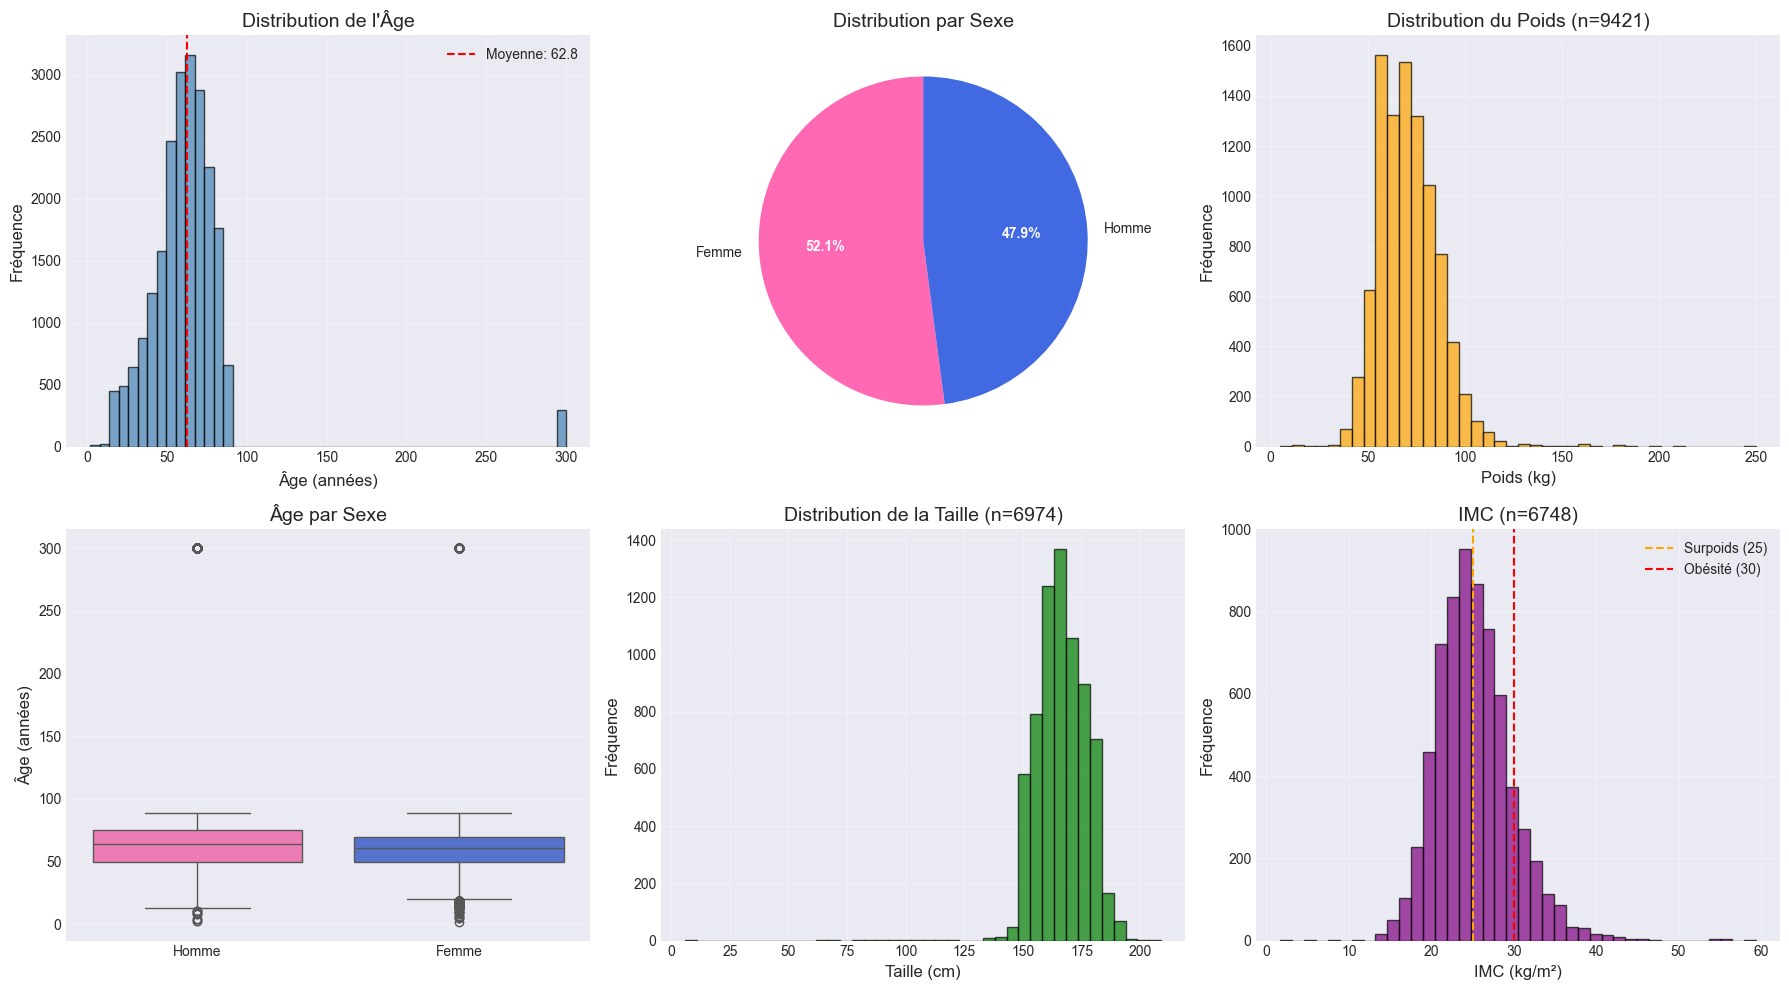

In [32]:
# ─────────────────────────────────────────────────────────────────────────────
# A.1 ANALYSE DÉMOGRAPHIQUE (EDA_01)
# ─────────────────────────────────────────────────────────────────────────────
print("[A.1] Génération: EDA_01_Demographics.png...")

fig = plt.figure(figsize=(18, 10))

# Distribution âge
ax1 = plt.subplot(2, 3, 1)
df_eda['age'].hist(bins=50, edgecolor='black', alpha=0.7, color='steelblue', ax=ax1)
ax1.axvline(df_eda['age'].mean(), color='red', linestyle='--', label=f'Moyenne: {df_eda["age"].mean():.1f}')
ax1.set_xlabel('Âge (années)')
ax1.set_ylabel('Fréquence')
ax1.set_title('Distribution de l\'Âge')
ax1.legend()
ax1.grid(alpha=0.3)

# Distribution par sexe
ax2 = plt.subplot(2, 3, 2)
sex_counts = df_eda['sex'].value_counts()
colors = ['#FF69B4', '#4169E1']
labels = ['Femme', 'Homme']
wedges, texts, autotexts = ax2.pie(sex_counts.values, labels=labels, autopct='%1.1f%%',
                                     startangle=90, colors=colors)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_weight('bold')
ax2.set_title('Distribution par Sexe')

# Poids
ax3 = plt.subplot(2, 3, 3)
df_eda['weight'].dropna().hist(bins=40, edgecolor='black', alpha=0.7, color='orange', ax=ax3)
ax3.set_xlabel('Poids (kg)')
ax3.set_ylabel('Fréquence')
ax3.set_title(f'Distribution du Poids (n={df_eda["weight"].notna().sum()})')
ax3.grid(alpha=0.3)

# Boxplot âge par sexe
ax4 = plt.subplot(2, 3, 4)
df_plot = df_eda.copy()
df_plot['sex_label'] = df_plot['sex'].map({0: 'Femme', 1: 'Homme'})
sns.boxplot(data=df_plot, x='sex_label', y='age', ax=ax4, palette=['#FF69B4', '#4169E1'])
ax4.set_xlabel('')
ax4.set_ylabel('Âge (années)')
ax4.set_title('Âge par Sexe')
ax4.grid(axis='y', alpha=0.3)

# Taille
ax5 = plt.subplot(2, 3, 5)
df_eda['height'].dropna().hist(bins=40, edgecolor='black', alpha=0.7, color='green', ax=ax5)
ax5.set_xlabel('Taille (cm)')
ax5.set_ylabel('Fréquence')
ax5.set_title(f'Distribution de la Taille (n={df_eda["height"].notna().sum()})')
ax5.grid(alpha=0.3)

# IMC
ax6 = plt.subplot(2, 3, 6)
df_eda['bmi'].dropna().hist(bins=40, edgecolor='black', alpha=0.7, color='purple', ax=ax6)
ax6.axvline(25, color='orange', linestyle='--', label='Surpoids (25)')
ax6.axvline(30, color='red', linestyle='--', label='Obésité (30)')
ax6.set_xlabel('IMC (kg/m²)')
ax6.set_ylabel('Fréquence')
ax6.set_title(f'IMC (n={df_eda["bmi"].notna().sum()})')
ax6.legend()
ax6.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('EDA_01_Demographics.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: EDA_01_Demographics.png")
plt.show()

[A.2] Génération: EDA_02_Diagnostics.png...
  ✓ Sauvegardé: EDA_02_Diagnostics.png


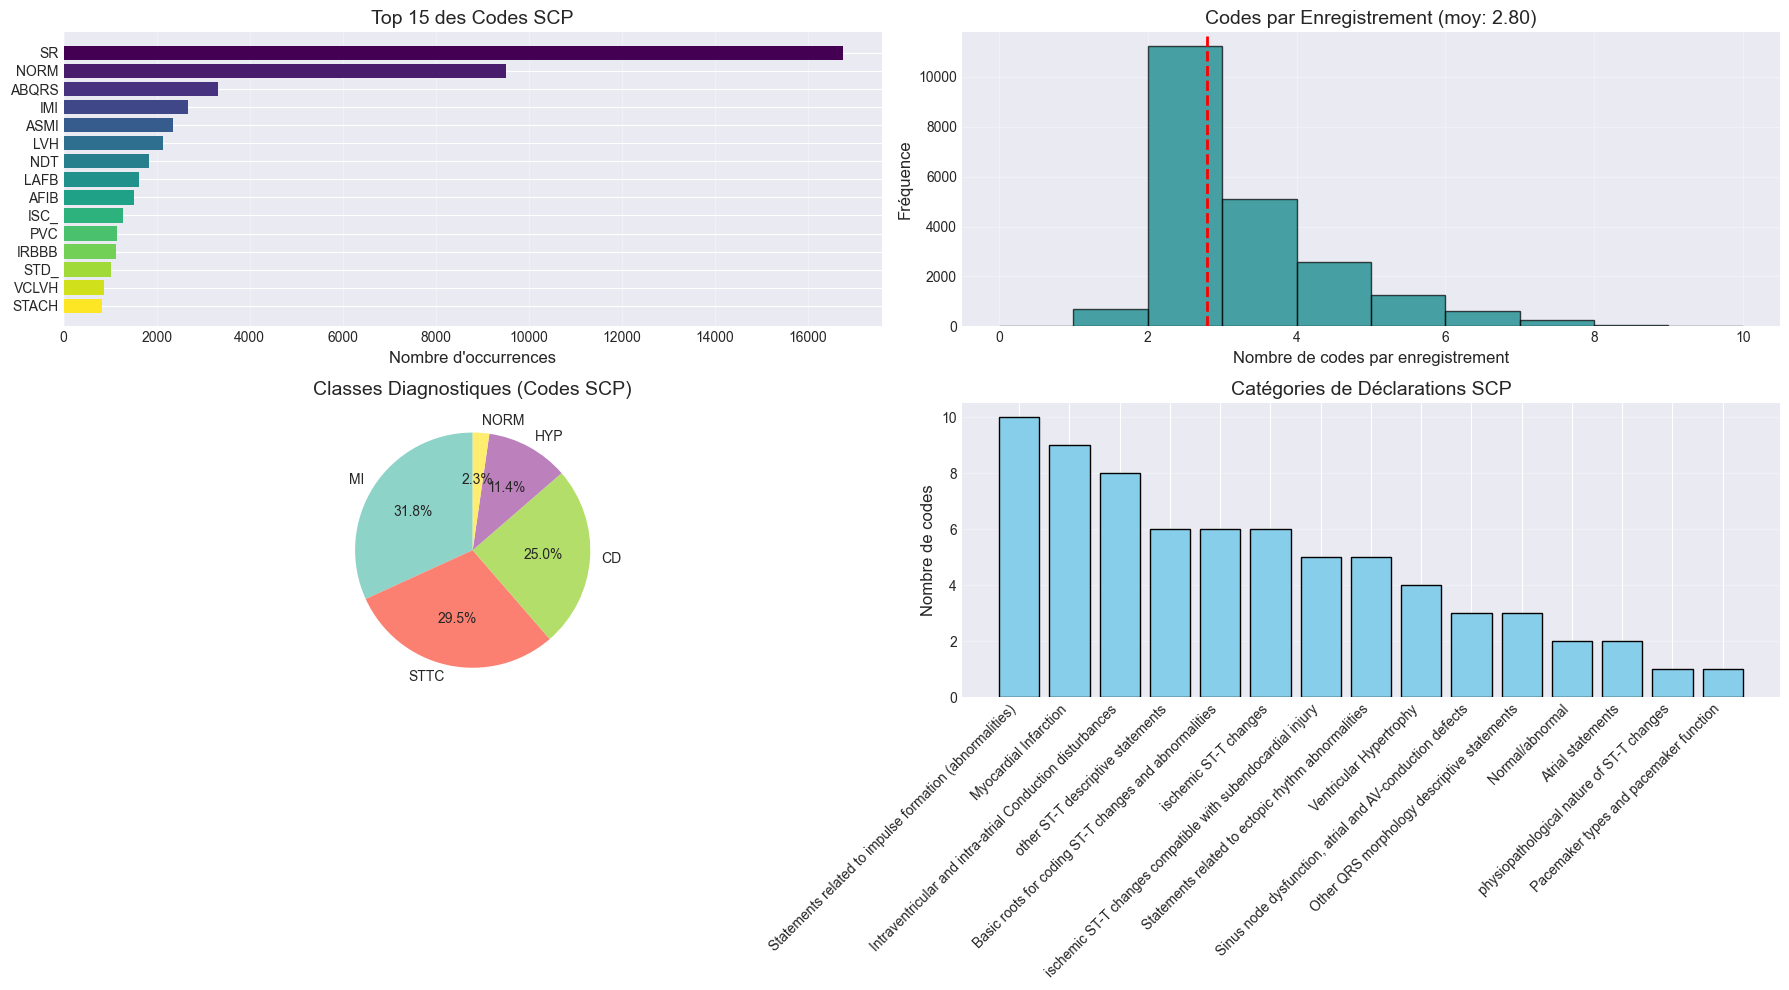

In [33]:
# ─────────────────────────────────────────────────────────────────────────────
# A.2 ANALYSE DES DIAGNOSTICS (EDA_02)
# ─────────────────────────────────────────────────────────────────────────────
print("[A.2] Génération: EDA_02_Diagnostics.png...")

fig = plt.figure(figsize=(18, 10))

# Top 15 codes SCP
ax1 = plt.subplot(2, 2, 1)
top_15 = scp_counter.most_common(15)
codes, counts = zip(*top_15)
colors_gradient = plt.cm.viridis(np.linspace(0, 1, len(codes)))
bars = ax1.barh(range(len(codes)), counts, color=colors_gradient)
ax1.set_yticks(range(len(codes)))
ax1.set_yticklabels(codes)
ax1.set_xlabel('Nombre d\'occurrences')
ax1.set_title('Top 15 des Codes SCP')
ax1.invert_yaxis()
ax1.grid(axis='x', alpha=0.3)

# Nombre de codes par enregistrement
ax2 = plt.subplot(2, 2, 2)
codes_per_record = df_eda['num_codes'].values
ax2.hist(codes_per_record, bins=range(0, max(codes_per_record)+2), edgecolor='black', alpha=0.7, color='teal')
ax2.set_xlabel('Nombre de codes par enregistrement')
ax2.set_ylabel('Fréquence')
ax2.set_title(f'Codes par Enregistrement (moy: {np.mean(codes_per_record):.2f})')
ax2.axvline(np.mean(codes_per_record), color='red', linestyle='--', linewidth=2)
ax2.grid(alpha=0.3)

# Classes diagnostiques
ax3 = plt.subplot(2, 2, 3)
diag_classes = scp_df[scp_df['diagnostic'] == 1.0]['diagnostic_class'].value_counts()
colors_diag = plt.cm.Set3(np.linspace(0, 1, len(diag_classes)))
wedges, texts, autotexts = ax3.pie(diag_classes.values, labels=diag_classes.index, 
                                     autopct='%1.1f%%', colors=colors_diag, startangle=90)
ax3.set_title('Classes Diagnostiques (Codes SCP)')

# Catégories de déclarations
ax4 = plt.subplot(2, 2, 4)
statement_cats = scp_df['Statement Category'].value_counts()
bars = ax4.bar(range(len(statement_cats)), statement_cats.values, color='skyblue', edgecolor='black')
ax4.set_xticks(range(len(statement_cats)))
ax4.set_xticklabels(statement_cats.index, rotation=45, ha='right')
ax4.set_ylabel('Nombre de codes')
ax4.set_title('Catégories de Déclarations SCP')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('EDA_02_Diagnostics.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: EDA_02_Diagnostics.png")
plt.show()

[A.3] Génération: EDA_03_Temporal.png...
  ✓ Sauvegardé: EDA_03_Temporal.png


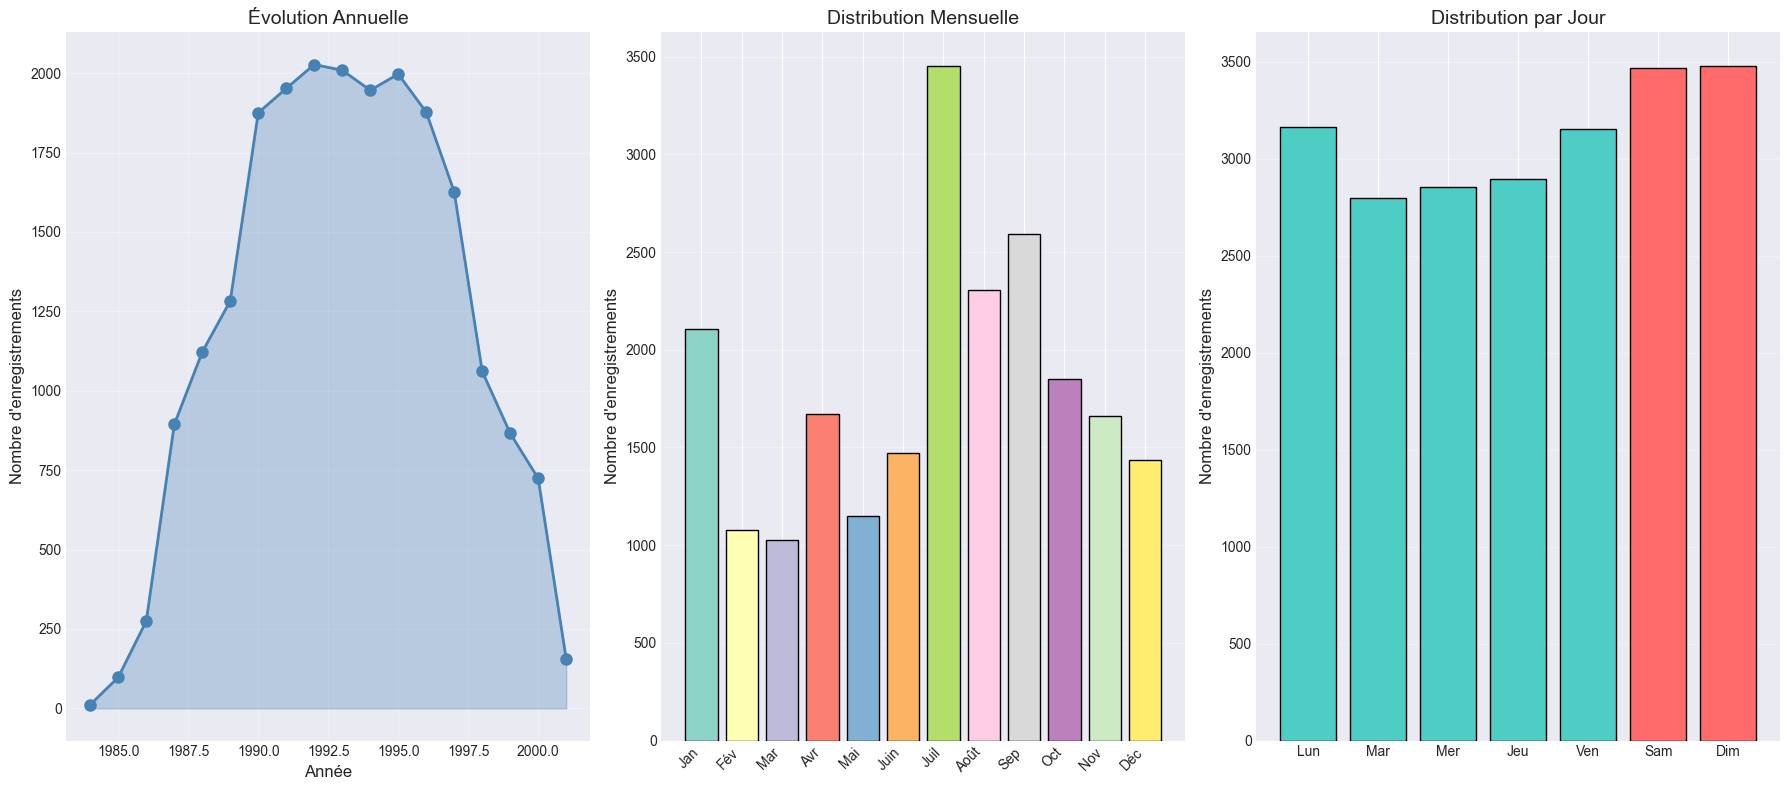

In [34]:
# ─────────────────────────────────────────────────────────────────────────────
# A.3 ANALYSE TEMPORELLE (EDA_03)
# ─────────────────────────────────────────────────────────────────────────────
print("[A.3] Génération: EDA_03_Temporal.png...")

fig = plt.figure(figsize=(18, 8))

# Évolution annuelle
ax1 = plt.subplot(1, 3, 1)
yearly = df_eda['year'].value_counts().sort_index()
ax1.plot(yearly.index, yearly.values, marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.fill_between(yearly.index, yearly.values, alpha=0.3, color='steelblue')
ax1.set_xlabel('Année')
ax1.set_ylabel('Nombre d\'enregistrements')
ax1.set_title('Évolution Annuelle')
ax1.grid(alpha=0.3)

# Distribution mensuelle
ax2 = plt.subplot(1, 3, 2)
monthly = df_eda['month'].value_counts().sort_index()
month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
colors_months = plt.cm.Set3(np.linspace(0, 1, 12))
ax2.bar(monthly.index, monthly.values, color=colors_months, edgecolor='black')
ax2.set_xticks(range(1, 13))
ax2.set_xticklabels(month_names, rotation=45, ha='right')
ax2.set_ylabel('Nombre d\'enregistrements')
ax2.set_title('Distribution Mensuelle')
ax2.grid(axis='y', alpha=0.3)

# Par jour de la semaine
ax3 = plt.subplot(1, 3, 3)
dow = df_eda['day_of_week'].value_counts().sort_index()
day_names = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
colors_days = ['#4ECDC4' if i < 5 else '#FF6B6B' for i in range(7)]
ax3.bar(range(7), [dow.get(i, 0) for i in range(7)], color=colors_days, edgecolor='black')
ax3.set_xticks(range(7))
ax3.set_xticklabels(day_names)
ax3.set_ylabel('Nombre d\'enregistrements')
ax3.set_title('Distribution par Jour')
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('EDA_03_Temporal.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: EDA_03_Temporal.png")
plt.show()

[A.4] Génération: EDA_04_Quality.png...
  ✓ Sauvegardé: EDA_04_Quality.png


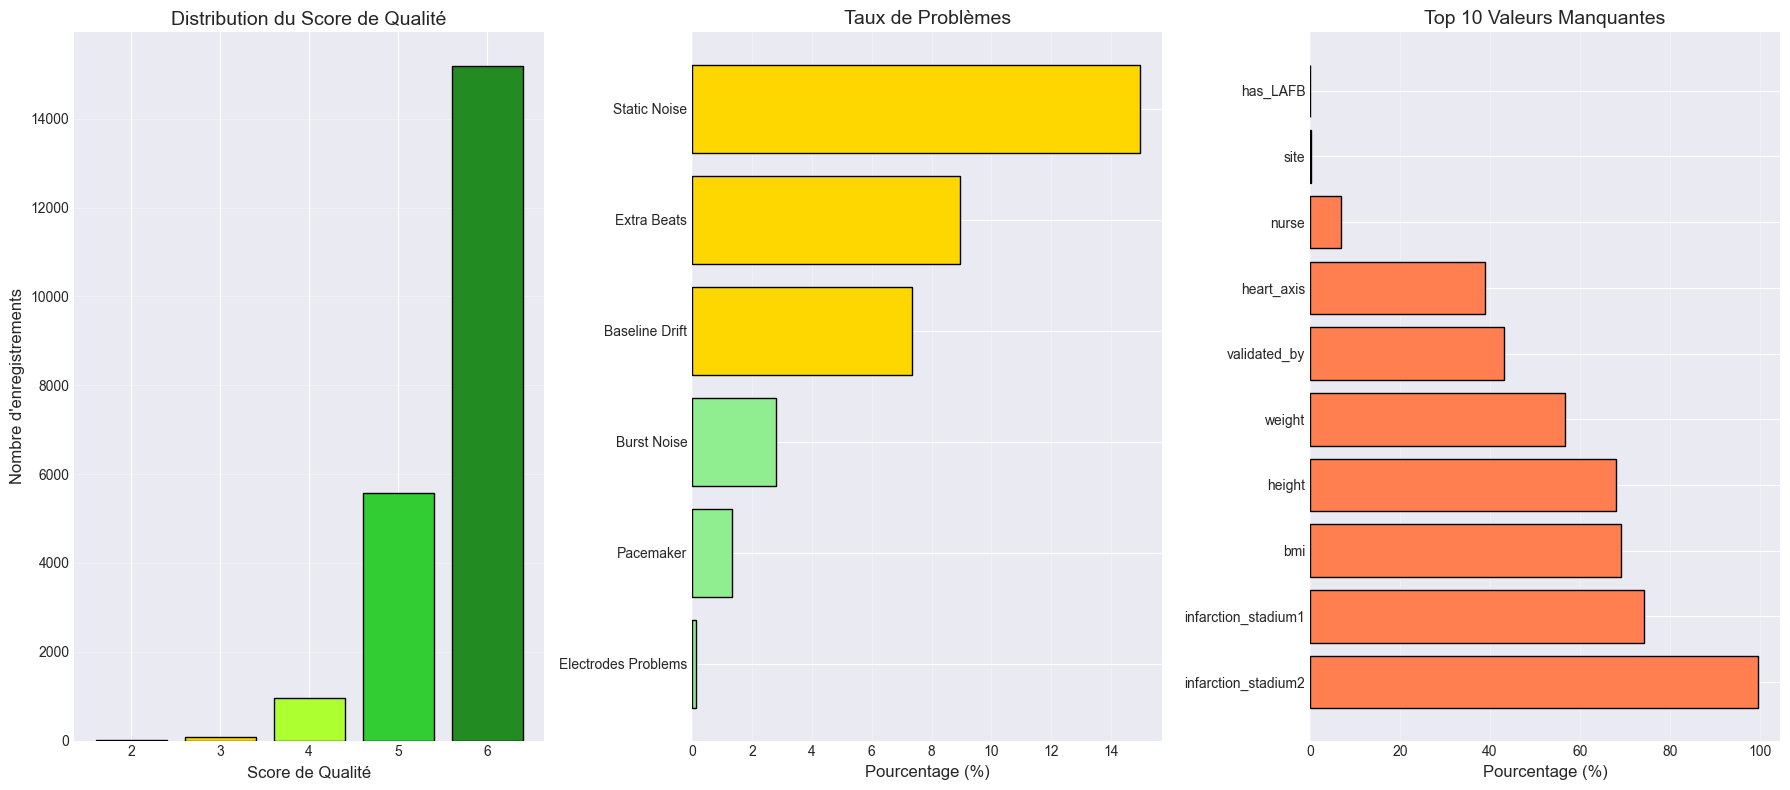

In [35]:
# ─────────────────────────────────────────────────────────────────────────────
# A.4 QUALITÉ DES DONNÉES (EDA_04)
# ─────────────────────────────────────────────────────────────────────────────
print("[A.4] Génération: EDA_04_Quality.png...")

fig = plt.figure(figsize=(18, 8))

# Distribution score qualité
ax1 = plt.subplot(1, 3, 1)
quality_counts = df_eda['quality_score'].value_counts().sort_index()
colors_quality = ['#FF0000', '#FF4500', '#FFA500', '#FFD700', '#ADFF2F', '#32CD32', '#228B22']
bars = ax1.bar(quality_counts.index, quality_counts.values,
              color=[colors_quality[int(i)] for i in quality_counts.index], edgecolor='black')
ax1.set_xlabel('Score de Qualité')
ax1.set_ylabel('Nombre d\'enregistrements')
ax1.set_title('Distribution du Score de Qualité')
ax1.grid(axis='y', alpha=0.3)

# Taux de problèmes
ax2 = plt.subplot(1, 3, 2)
quality_issues_pct = pd.Series({col: df_eda[col].sum() / len(df_eda) * 100 for col in quality_cols})
quality_issues_pct = quality_issues_pct.sort_values(ascending=True)
colors_issues = ['#90EE90' if x < 5 else '#FFD700' if x < 15 else '#FF6B6B' for x in quality_issues_pct.values]
bars = ax2.barh(range(len(quality_issues_pct)), quality_issues_pct.values, color=colors_issues, edgecolor='black')
ax2.set_yticks(range(len(quality_issues_pct)))
ax2.set_yticklabels([col.replace('_', ' ').title() for col in quality_issues_pct.index])
ax2.set_xlabel('Pourcentage (%)')
ax2.set_title('Taux de Problèmes')
ax2.grid(axis='x', alpha=0.3)

# Valeurs manquantes
ax3 = plt.subplot(1, 3, 3)
missing = df_eda.isnull().sum().sort_values(ascending=False).head(10)
missing_pct = (missing / len(df_eda) * 100)
bars = ax3.barh(range(len(missing)), missing_pct.values, color='coral', edgecolor='black')
ax3.set_yticks(range(len(missing)))
ax3.set_yticklabels(missing.index)
ax3.set_xlabel('Pourcentage (%)')
ax3.set_title('Top 10 Valeurs Manquantes')
ax3.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('EDA_04_Quality.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: EDA_04_Quality.png")
plt.show()

## 📈 PARTIE B: ANALYSE DES DÉPENDANCES

Analyse des relations entre variables démographiques et codes SCP.

[B.1] Génération: Dependances_01_Age_Codes.png...
  ✓ Sauvegardé: Dependances_01_Age_Codes.png


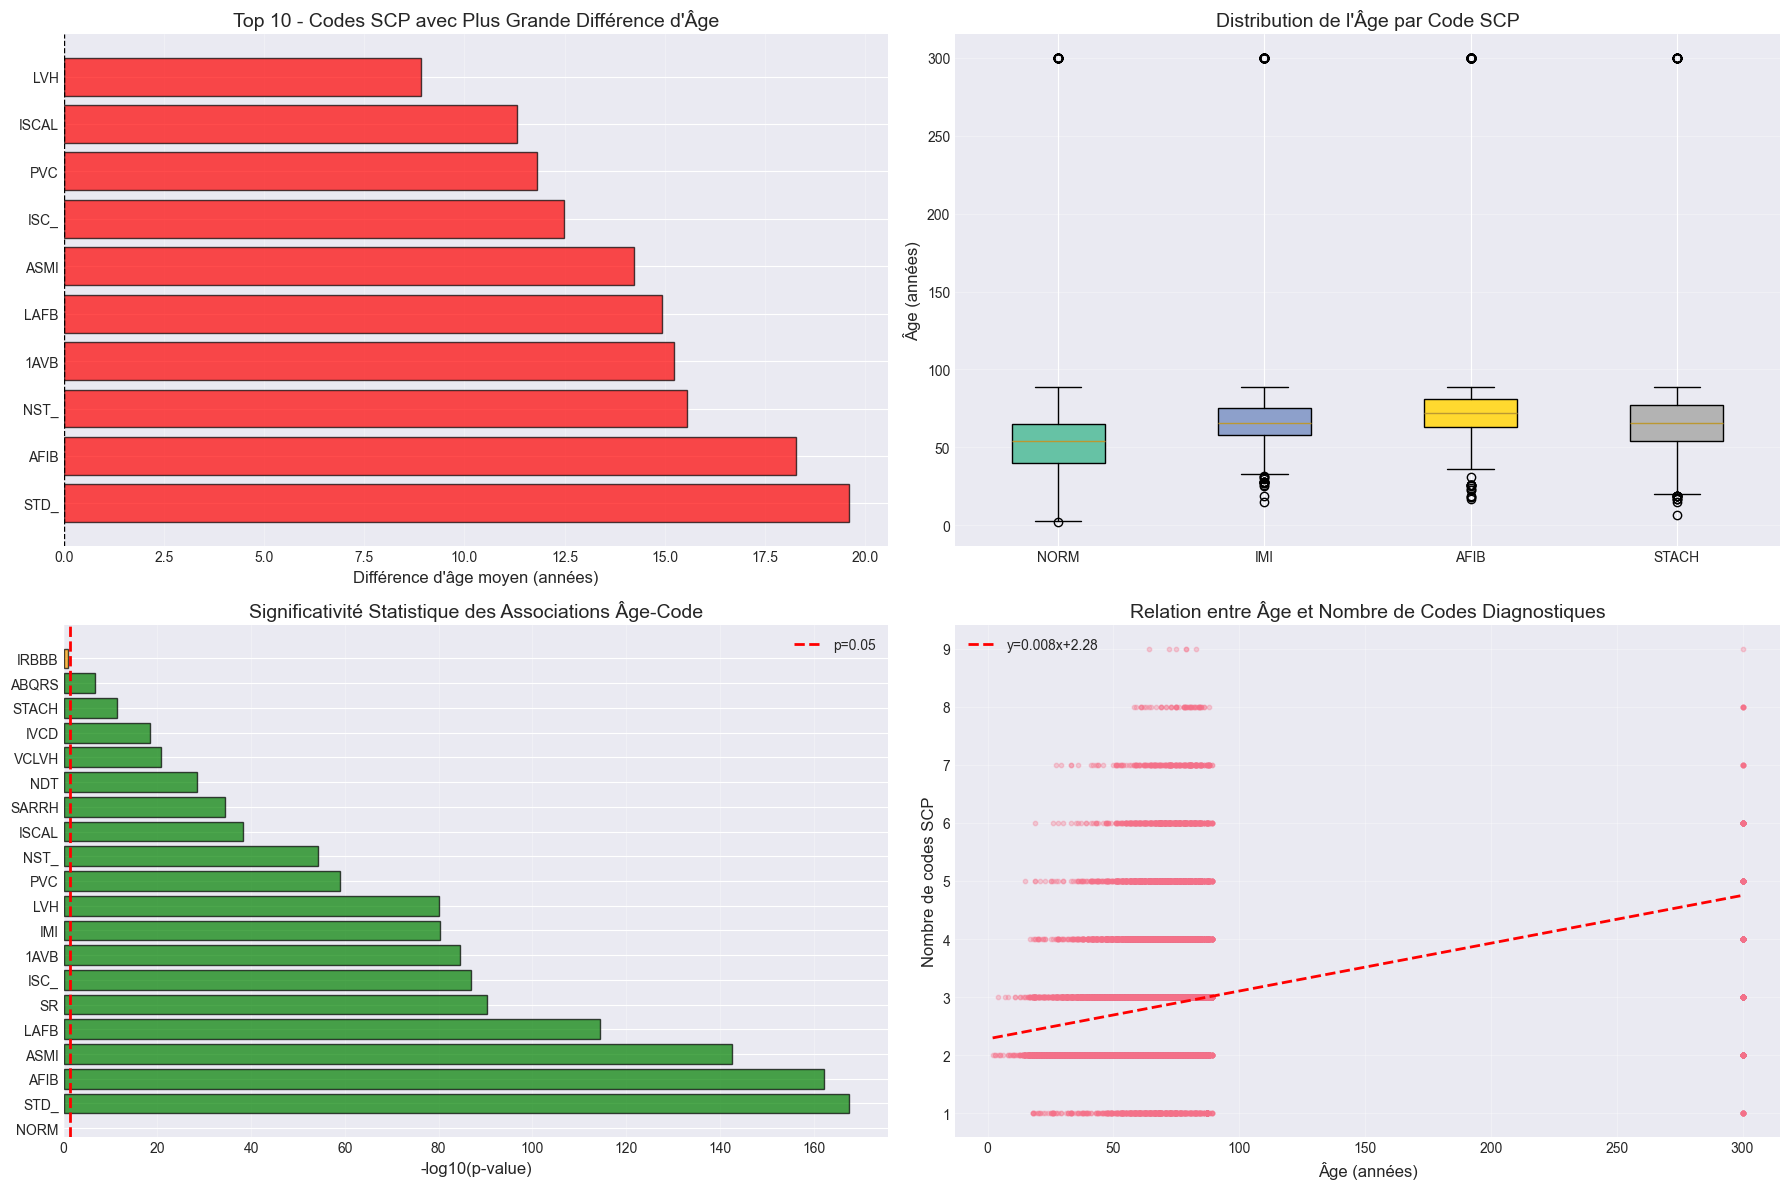

In [36]:
# ─────────────────────────────────────────────────────────────────────────────
# B.1 DÉPENDANCE ÂGE vs CODES SCP (Dependances_01)
# ─────────────────────────────────────────────────────────────────────────────
print("[B.1] Génération: Dependances_01_Age_Codes.png...")

age_analysis = []
for code in top_20_codes:
    with_code = df_eda[df_eda[f'has_{code}'] == 1]['age']
    without_code = df_eda[df_eda[f'has_{code}'] == 0]['age']
    
    if len(with_code) > 10 and len(without_code) > 10:
        stat, p_value = mannwhitneyu(with_code, without_code, alternative='two-sided')
        age_analysis.append({
            'Code': code,
            'Age_Avec': with_code.mean(),
            'Age_Sans': without_code.mean(),
            'Difference': with_code.mean() - without_code.mean(),
            'P_Value': p_value,
            'Significatif': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'NS'
        })

age_df = pd.DataFrame(age_analysis).sort_values('Difference', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Top 10 différences d'âge
ax1 = axes[0, 0]
top_10_age = age_df.head(10)
colors = ['red' if x > 0 else 'blue' for x in top_10_age['Difference']]
ax1.barh(range(len(top_10_age)), top_10_age['Difference'], color=colors, alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(top_10_age)))
ax1.set_yticklabels(top_10_age['Code'])
ax1.set_xlabel('Différence d\'âge moyen (années)')
ax1.set_title('Top 10 - Codes SCP avec Plus Grande Différence d\'Âge')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax1.grid(axis='x', alpha=0.3)

# 2. Distribution d'âge pour quelques codes
ax2 = axes[0, 1]
codes_to_plot = ['NORM', 'IMI', 'AFIB', 'STACH']
data_to_plot = []
labels = []
for code in codes_to_plot:
    if f'has_{code}' in df_eda.columns:
        data_to_plot.append(df_eda[df_eda[f'has_{code}'] == 1]['age'].dropna().values)
        labels.append(code)

if data_to_plot:
    bp = ax2.boxplot(data_to_plot, labels=labels, patch_artist=True)
    colors_box = plt.cm.Set2(np.linspace(0, 1, len(data_to_plot)))
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
    ax2.set_ylabel('Âge (années)')
    ax2.set_title('Distribution de l\'Âge par Code SCP')
    ax2.grid(axis='y', alpha=0.3)

# 3. P-values
ax3 = axes[1, 0]
age_df_sorted = age_df.sort_values('P_Value')
colors_p = ['green' if p < 0.05 else 'orange' for p in age_df_sorted['P_Value']]
ax3.barh(range(len(age_df_sorted)), -np.log10(age_df_sorted['P_Value']), color=colors_p, alpha=0.7, edgecolor='black')
ax3.set_yticks(range(len(age_df_sorted)))
ax3.set_yticklabels(age_df_sorted['Code'])
ax3.axvline(x=-np.log10(0.05), color='red', linestyle='--', linewidth=2, label='p=0.05')
ax3.set_xlabel('-log10(p-value)')
ax3.set_title('Significativité Statistique des Associations Âge-Code')
ax3.legend()
ax3.grid(axis='x', alpha=0.3)

# 4. Scatter âge vs nombre de codes
ax4 = axes[1, 1]
ax4.scatter(df_eda['age'], df_eda['num_codes'], alpha=0.3, s=10)
ax4.set_xlabel('Âge (années)')
ax4.set_ylabel('Nombre de codes SCP')
ax4.set_title('Relation entre Âge et Nombre de Codes Diagnostiques')
ax4.grid(alpha=0.3)
z = np.polyfit(df_eda['age'].dropna(), df_eda.loc[df_eda['age'].notna(), 'num_codes'], 1)
p = np.poly1d(z)
age_sorted = df_eda['age'].dropna().sort_values()
ax4.plot(age_sorted, p(age_sorted), "r--", linewidth=2, label=f'y={z[0]:.3f}x+{z[1]:.2f}')
ax4.legend()

plt.tight_layout()
plt.savefig('Dependances_01_Age_Codes.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: Dependances_01_Age_Codes.png")
plt.show()

[B.2] Génération: Dependances_02_Sexe_Codes.png...
  ✓ Sauvegardé: Dependances_02_Sexe_Codes.png


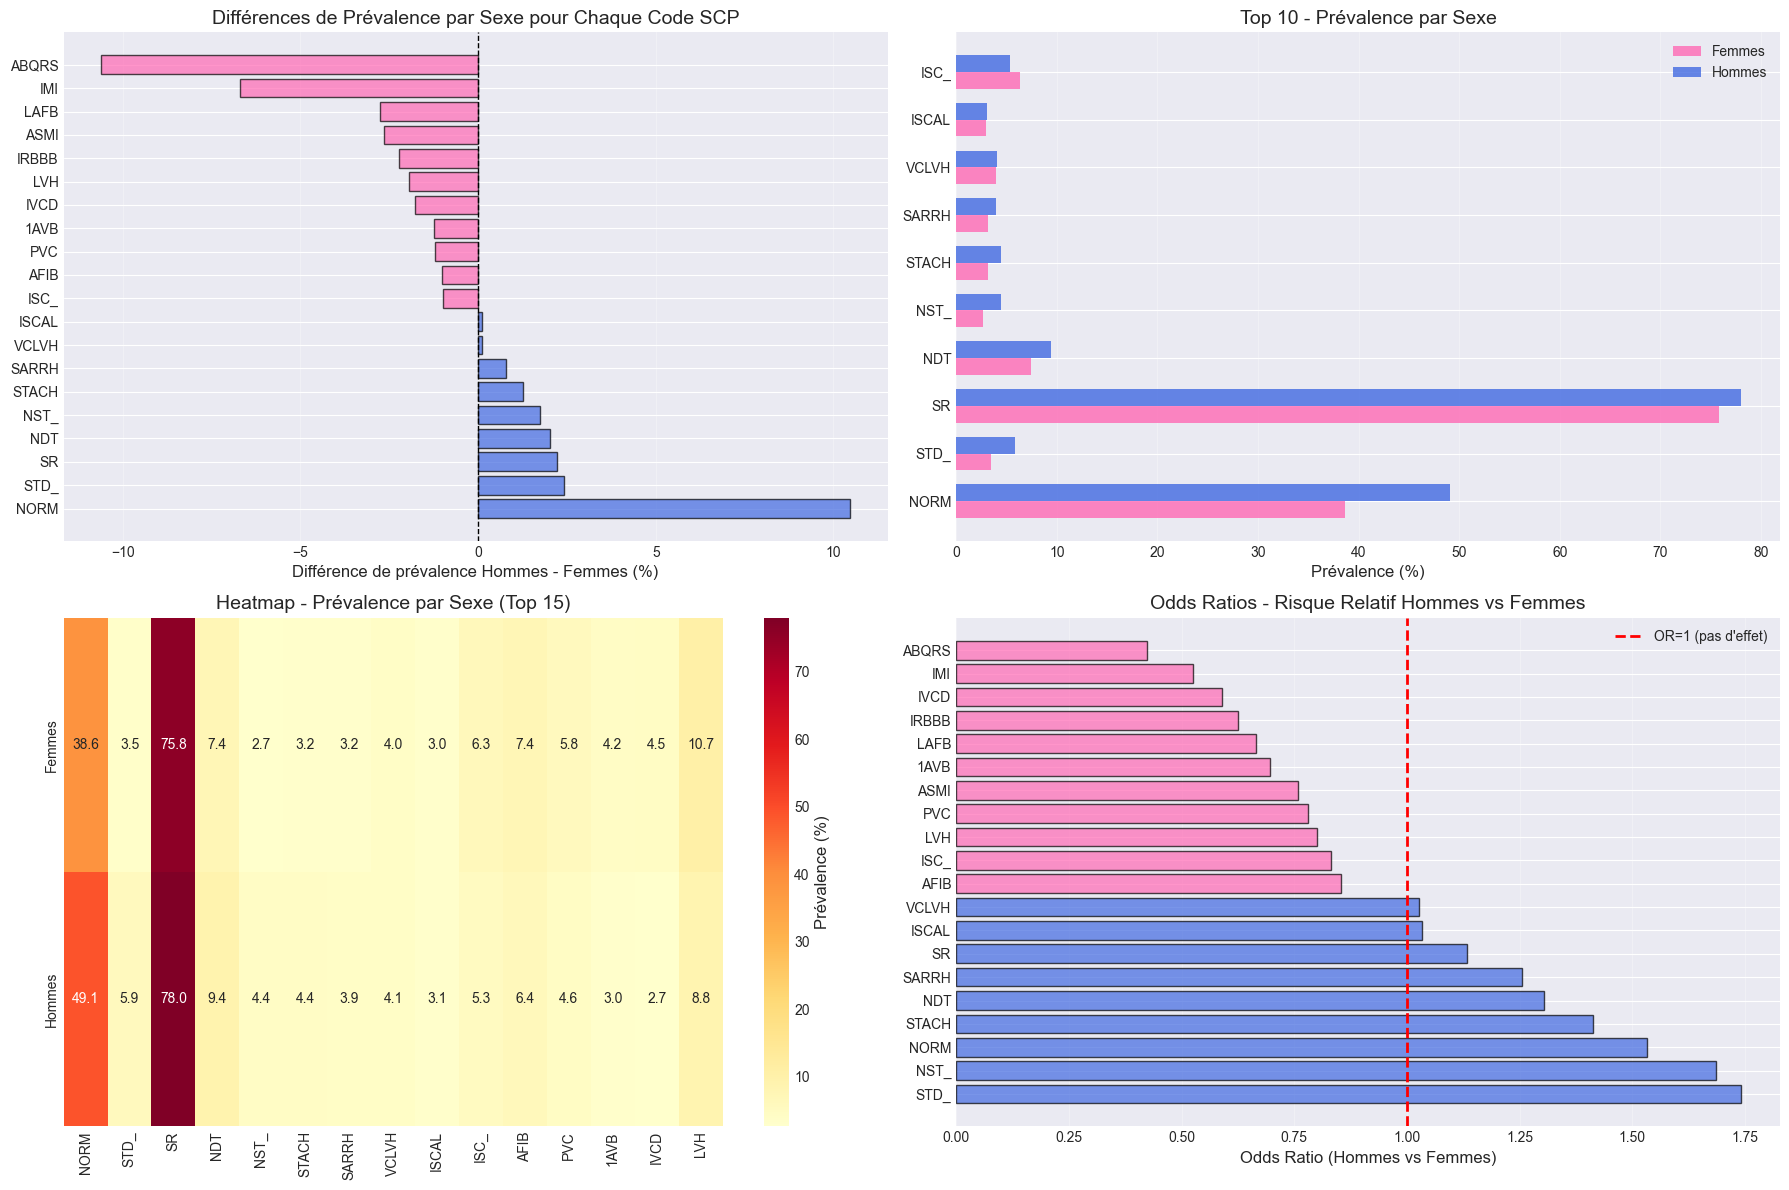

In [37]:
# ─────────────────────────────────────────────────────────────────────────────
# B.2 DÉPENDANCE SEXE vs CODES SCP (Dependances_02)
# ─────────────────────────────────────────────────────────────────────────────
print("[B.2] Génération: Dependances_02_Sexe_Codes.png...")

sex_analysis = []
for code in top_20_codes:
    femmes = df_eda[df_eda['sex'] == 0]
    hommes = df_eda[df_eda['sex'] == 1]
    
    prev_femmes = femmes[f'has_{code}'].mean() * 100
    prev_hommes = hommes[f'has_{code}'].mean() * 100
    
    contingency = pd.crosstab(df_eda['sex'], df_eda[f'has_{code}'])
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    
    sex_analysis.append({
        'Code': code,
        'Prevalence_Femmes': prev_femmes,
        'Prevalence_Hommes': prev_hommes,
        'Difference': prev_hommes - prev_femmes,
        'P_Value': p_value,
        'Significatif': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'NS'
    })

sex_df = pd.DataFrame(sex_analysis).sort_values('Difference', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Différences de prévalence
ax1 = axes[0, 0]
colors = ['#FF69B4' if x < 0 else '#4169E1' for x in sex_df['Difference']]
ax1.barh(range(len(sex_df)), sex_df['Difference'], color=colors, alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(sex_df)))
ax1.set_yticklabels(sex_df['Code'])
ax1.set_xlabel('Différence de prévalence Hommes - Femmes (%)')
ax1.set_title('Différences de Prévalence par Sexe pour Chaque Code SCP')
ax1.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax1.grid(axis='x', alpha=0.3)

# 2. Comparaison prévalences
ax2 = axes[0, 1]
x = np.arange(len(sex_df.head(10)))
width = 0.35
ax2.barh(x - width/2, sex_df.head(10)['Prevalence_Femmes'], width, label='Femmes', color='#FF69B4', alpha=0.8)
ax2.barh(x + width/2, sex_df.head(10)['Prevalence_Hommes'], width, label='Hommes', color='#4169E1', alpha=0.8)
ax2.set_yticks(x)
ax2.set_yticklabels(sex_df.head(10)['Code'])
ax2.set_xlabel('Prévalence (%)')
ax2.set_title('Top 10 - Prévalence par Sexe')
ax2.legend()
ax2.grid(axis='x', alpha=0.3)

# 3. Heatmap prévalence
ax3 = axes[1, 0]
heatmap_data = sex_df[['Prevalence_Femmes', 'Prevalence_Hommes']].head(15).T
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax3, 
            xticklabels=sex_df.head(15)['Code'], 
            yticklabels=['Femmes', 'Hommes'],
            cbar_kws={'label': 'Prévalence (%)'})
ax3.set_title('Heatmap - Prévalence par Sexe (Top 15)')

# 4. Odds ratio
ax4 = axes[1, 1]
odds_ratios = []
for code in top_20_codes:
    contingency = pd.crosstab(df_eda['sex'], df_eda[f'has_{code}'])
    a, b = contingency.iloc[1, 1], contingency.iloc[1, 0]  # Hommes avec/sans
    c, d = contingency.iloc[0, 1], contingency.iloc[0, 0]  # Femmes avec/sans
    odds_ratio = (a * d) / (b * c) if (b * c) > 0 else np.nan
    odds_ratios.append({'Code': code, 'OR': odds_ratio})

or_df = pd.DataFrame(odds_ratios).sort_values('OR', ascending=False)
colors_or = ['#4169E1' if x > 1 else '#FF69B4' for x in or_df['OR']]
ax4.barh(range(len(or_df)), or_df['OR'], color=colors_or, alpha=0.7, edgecolor='black')
ax4.set_yticks(range(len(or_df)))
ax4.set_yticklabels(or_df['Code'])
ax4.axvline(x=1, color='red', linestyle='--', linewidth=2, label='OR=1 (pas d\'effet)')
ax4.set_xlabel('Odds Ratio (Hommes vs Femmes)')
ax4.set_title('Odds Ratios - Risque Relatif Hommes vs Femmes')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('Dependances_02_Sexe_Codes.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: Dependances_02_Sexe_Codes.png")
plt.show()

[B.3] Génération: Dependances_03_Anthropometrie_Codes.png...
  ✓ Sauvegardé: Dependances_03_Anthropometrie_Codes.png


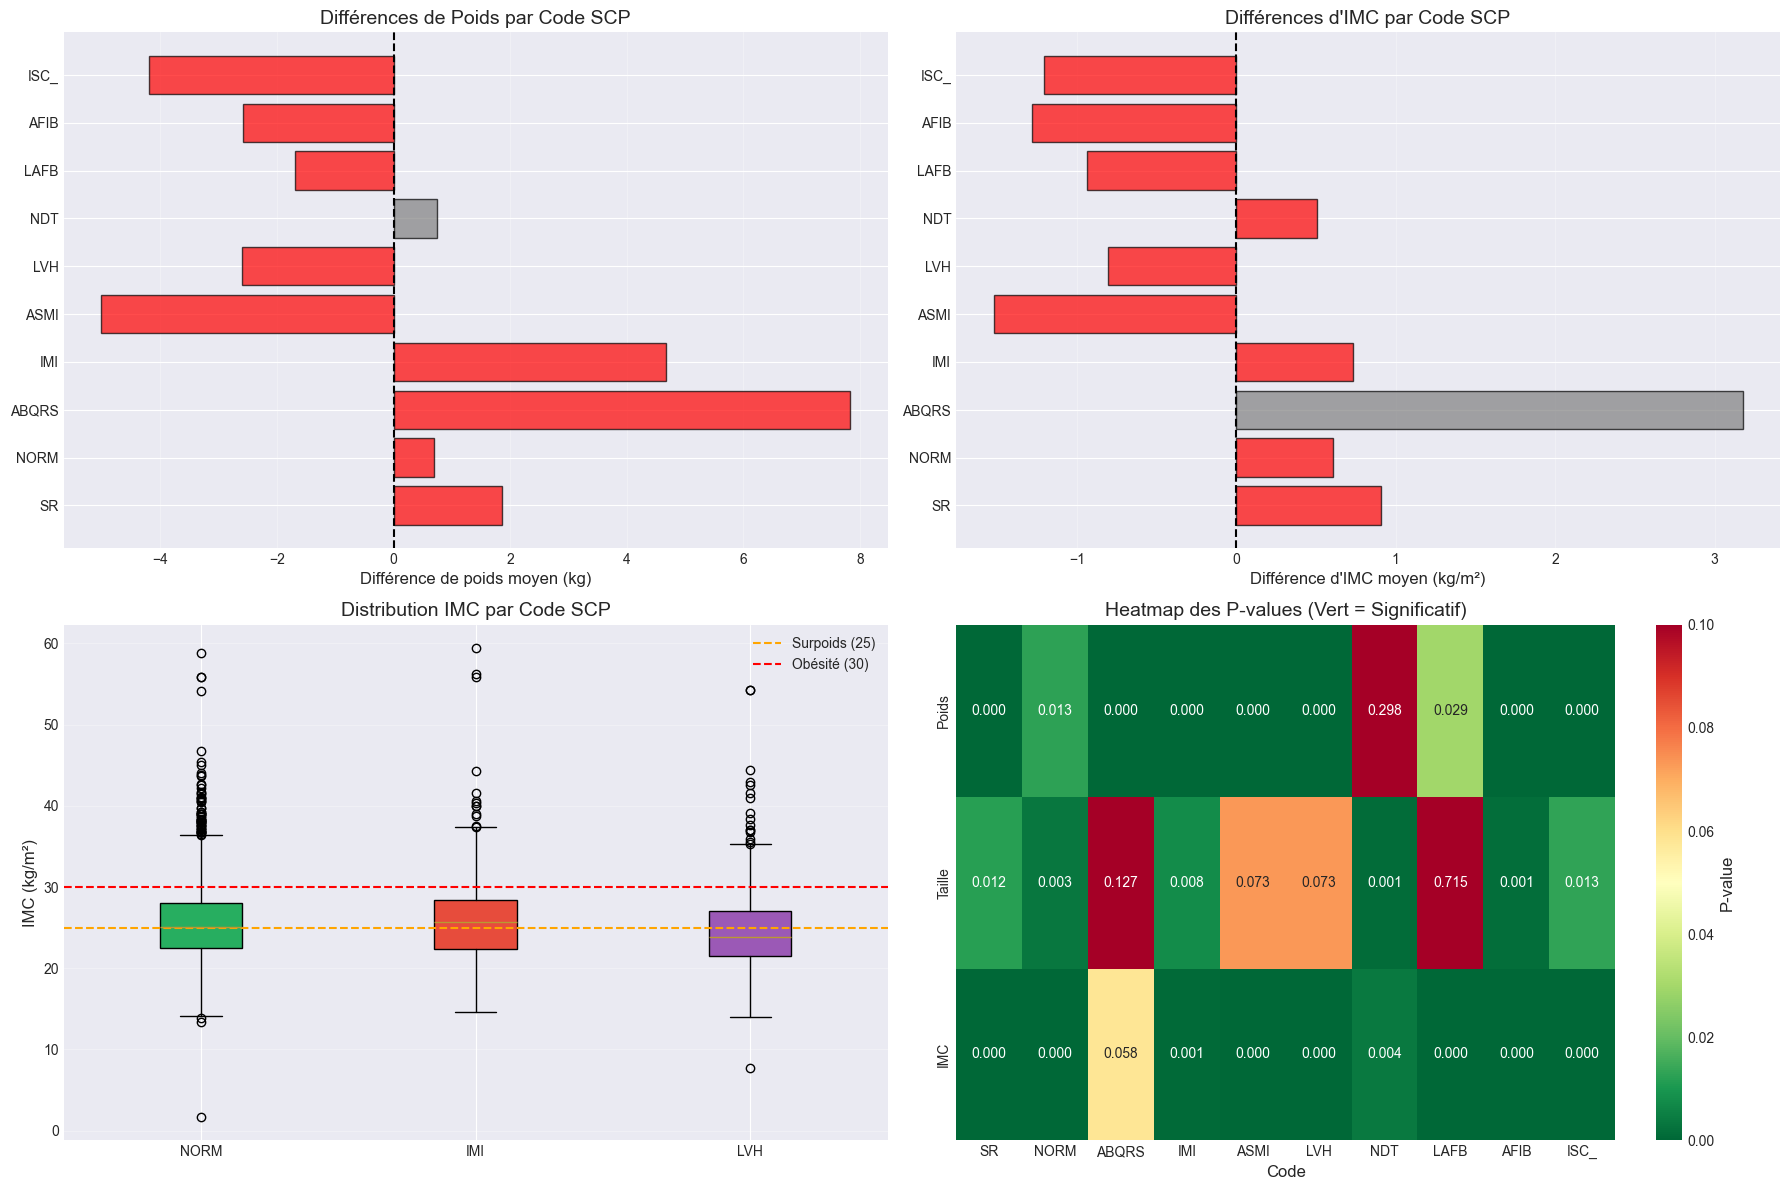

In [38]:
# ─────────────────────────────────────────────────────────────────────────────
# B.3 DÉPENDANCE ANTHROPOMÉTRIE vs CODES SCP (Dependances_03)
# ─────────────────────────────────────────────────────────────────────────────
print("[B.3] Génération: Dependances_03_Anthropometrie_Codes.png...")

anthro_analysis = []
for code in top_20_codes[:10]:
    with_code = df_eda[df_eda[f'has_{code}'] == 1]
    without_code = df_eda[df_eda[f'has_{code}'] == 0]
    
    result = {'Code': code}
    
    # Poids
    w1 = with_code['weight'].dropna()
    w0 = without_code['weight'].dropna()
    if len(w1) > 10 and len(w0) > 10:
        stat, p = mannwhitneyu(w1, w0)
        result['Weight_Diff'] = w1.mean() - w0.mean()
        result['Weight_P'] = p
    
    # Taille
    h1 = with_code['height'].dropna()
    h0 = without_code['height'].dropna()
    if len(h1) > 10 and len(h0) > 10:
        stat, p = mannwhitneyu(h1, h0)
        result['Height_Diff'] = h1.mean() - h0.mean()
        result['Height_P'] = p
    
    # IMC
    b1 = with_code['bmi'].dropna()
    b0 = without_code['bmi'].dropna()
    if len(b1) > 10 and len(b0) > 10:
        stat, p = mannwhitneyu(b1, b0)
        result['BMI_Diff'] = b1.mean() - b0.mean()
        result['BMI_P'] = p
    
    anthro_analysis.append(result)

anthro_df = pd.DataFrame(anthro_analysis)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Différences de poids
ax1 = axes[0, 0]
valid_weight = anthro_df.dropna(subset=['Weight_Diff'])
colors = ['red' if p < 0.05 else 'gray' for p in valid_weight['Weight_P']]
ax1.barh(range(len(valid_weight)), valid_weight['Weight_Diff'], color=colors, alpha=0.7, edgecolor='black')
ax1.set_yticks(range(len(valid_weight)))
ax1.set_yticklabels(valid_weight['Code'])
ax1.set_xlabel('Différence de poids moyen (kg)')
ax1.set_title('Différences de Poids par Code SCP')
ax1.axvline(x=0, color='black', linestyle='--')
ax1.grid(axis='x', alpha=0.3)

# 2. Différences d'IMC
ax2 = axes[0, 1]
valid_bmi = anthro_df.dropna(subset=['BMI_Diff'])
colors = ['red' if p < 0.05 else 'gray' for p in valid_bmi['BMI_P']]
ax2.barh(range(len(valid_bmi)), valid_bmi['BMI_Diff'], color=colors, alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(valid_bmi)))
ax2.set_yticklabels(valid_bmi['Code'])
ax2.set_xlabel('Différence d\'IMC moyen (kg/m²)')
ax2.set_title('Différences d\'IMC par Code SCP')
ax2.axvline(x=0, color='black', linestyle='--')
ax2.grid(axis='x', alpha=0.3)

# 3. Distribution IMC pour codes sélectionnés
ax3 = axes[1, 0]
codes_to_plot = ['NORM', 'IMI', 'LVH']
data_to_plot = []
labels = []
for code in codes_to_plot:
    if f'has_{code}' in df_eda.columns:
        data_to_plot.append(df_eda[df_eda[f'has_{code}'] == 1]['bmi'].dropna().values)
        labels.append(code)

if data_to_plot:
    bp = ax3.boxplot(data_to_plot, labels=labels, patch_artist=True)
    colors_box = ['#27ae60', '#e74c3c', '#9b59b6']
    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)
    ax3.axhline(y=25, color='orange', linestyle='--', label='Surpoids (25)')
    ax3.axhline(y=30, color='red', linestyle='--', label='Obésité (30)')
    ax3.set_ylabel('IMC (kg/m²)')
    ax3.set_title('Distribution IMC par Code SCP')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

# 4. Heatmap des p-values
ax4 = axes[1, 1]
heatmap_data = anthro_df[['Weight_P', 'Height_P', 'BMI_P']].T
heatmap_data.columns = anthro_df['Code']
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn_r', ax=ax4,
            yticklabels=['Poids', 'Taille', 'IMC'],
            vmin=0, vmax=0.1, cbar_kws={'label': 'P-value'})
ax4.set_title('Heatmap des P-values (Vert = Significatif)')

plt.tight_layout()
plt.savefig('Dependances_03_Anthropometrie_Codes.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: Dependances_03_Anthropometrie_Codes.png")
plt.show()

[B.4] Génération: Dependances_04_Temporel_Codes.png...
  ✓ Sauvegardé: Dependances_04_Temporel_Codes.png


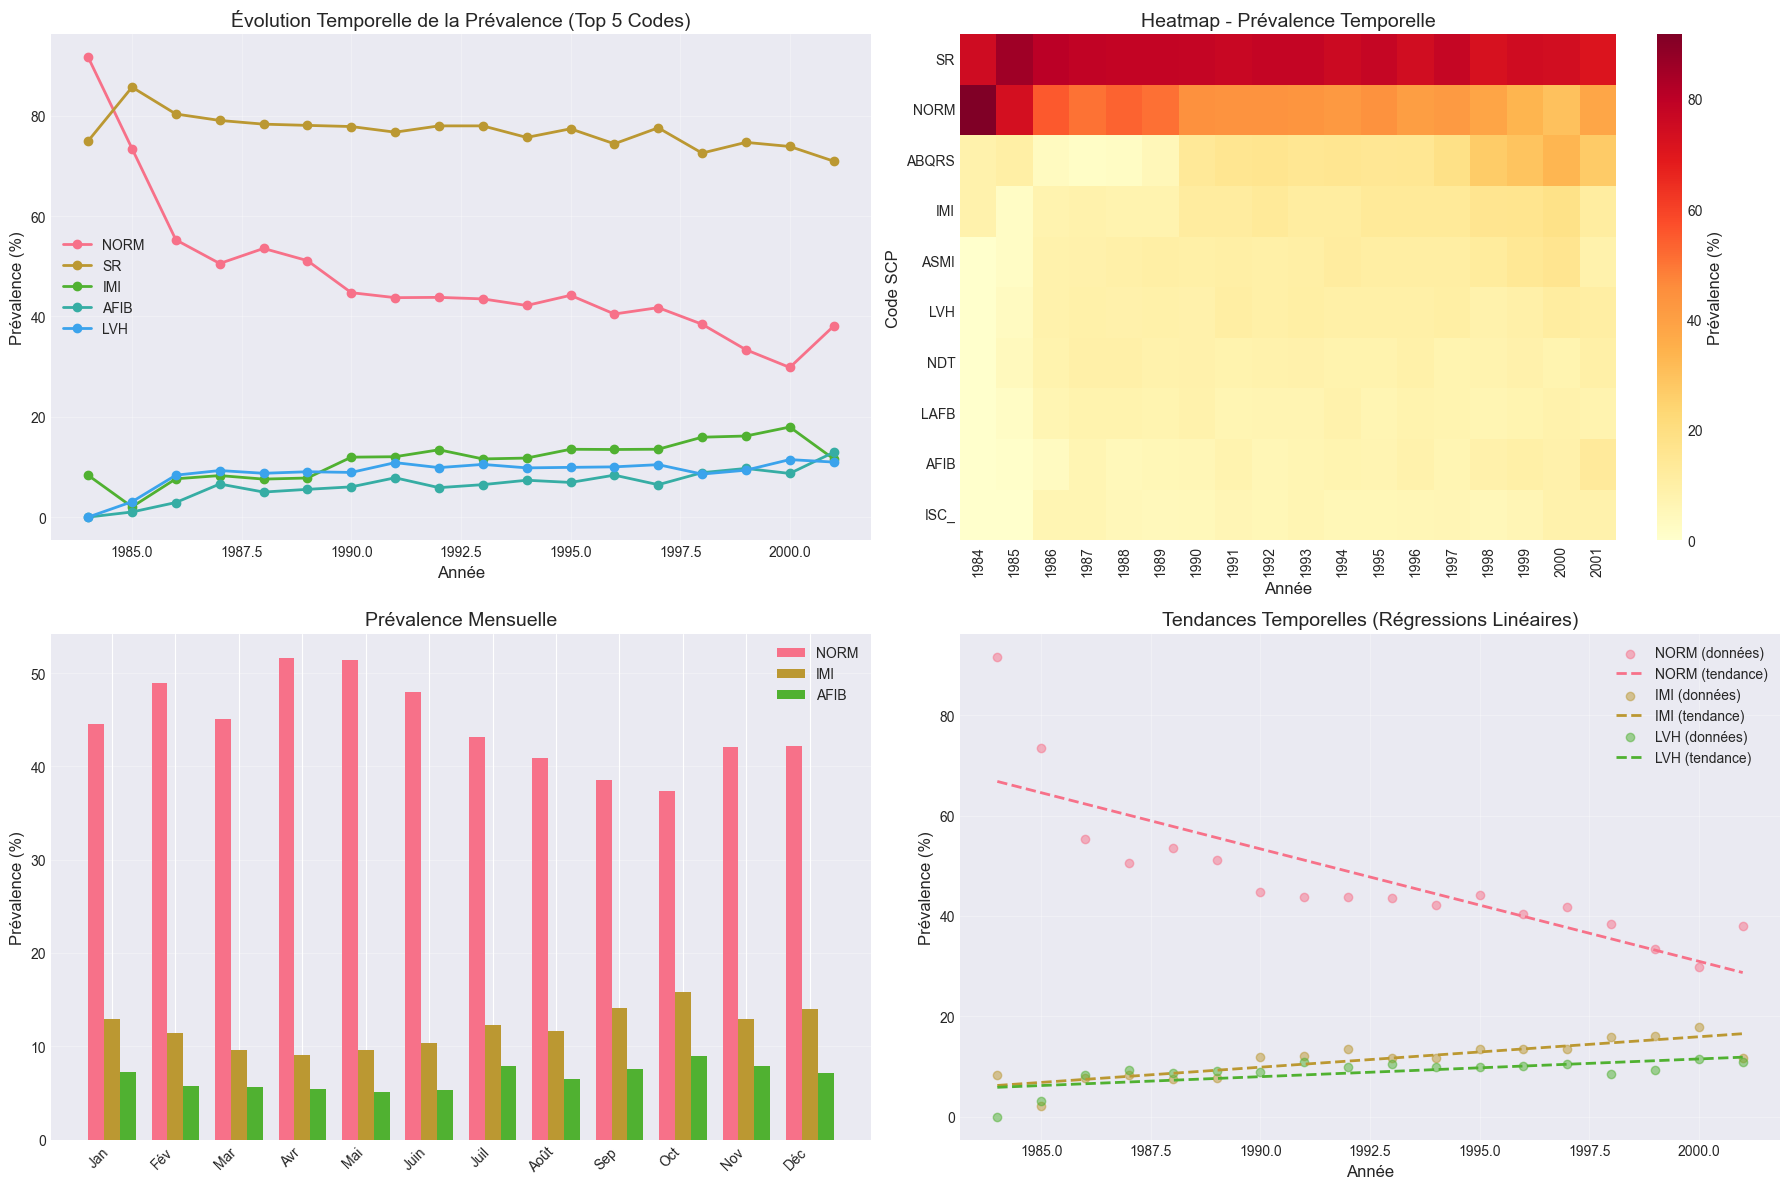

In [39]:
# ─────────────────────────────────────────────────────────────────────────────
# B.4 ÉVOLUTION TEMPORELLE DES CODES (Dependances_04)
# ─────────────────────────────────────────────────────────────────────────────
print("[B.4] Génération: Dependances_04_Temporel_Codes.png...")

temporal_analysis = {}
for code in top_20_codes[:10]:
    temporal_analysis[code] = df_eda.groupby('year')[f'has_{code}'].mean() * 100

temporal_df = pd.DataFrame(temporal_analysis).fillna(0)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Évolution temporelle top 5
ax1 = axes[0, 0]
for code in ['NORM', 'SR', 'IMI', 'AFIB', 'LVH']:
    if code in temporal_df.columns:
        ax1.plot(temporal_df.index, temporal_df[code], marker='o', label=code, linewidth=2)
ax1.set_xlabel('Année')
ax1.set_ylabel('Prévalence (%)')
ax1.set_title('Évolution Temporelle de la Prévalence (Top 5 Codes)')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Heatmap temporelle
ax2 = axes[0, 1]
sns.heatmap(temporal_df.T, cmap='YlOrRd', ax=ax2, cbar_kws={'label': 'Prévalence (%)'})
ax2.set_xlabel('Année')
ax2.set_ylabel('Code SCP')
ax2.set_title('Heatmap - Prévalence Temporelle')

# 3. Distribution par mois
ax3 = axes[1, 0]
monthly_counts = {}
for code in ['NORM', 'IMI', 'AFIB']:
    if f'has_{code}' in df_eda.columns:
        monthly_counts[code] = df_eda.groupby('month')[f'has_{code}'].mean() * 100

if monthly_counts:
    month_names = ['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Juin', 'Juil', 'Août', 'Sep', 'Oct', 'Nov', 'Déc']
    x = np.arange(12)
    width = 0.25
    for i, (code, data) in enumerate(monthly_counts.items()):
        ax3.bar(x + i*width, [data.get(m+1, 0) for m in range(12)], width, label=code)
    ax3.set_xticks(x + width)
    ax3.set_xticklabels(month_names, rotation=45, ha='right')
    ax3.set_ylabel('Prévalence (%)')
    ax3.set_title('Prévalence Mensuelle')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

# 4. Tendances
ax4 = axes[1, 1]
for code in ['NORM', 'IMI', 'LVH']:
    if code in temporal_df.columns:
        y = temporal_df[code].values
        x = temporal_df.index.values
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax4.scatter(x, y, alpha=0.5, label=f'{code} (données)')
        ax4.plot(x, p(x), '--', linewidth=2, label=f'{code} (tendance)')

ax4.set_xlabel('Année')
ax4.set_ylabel('Prévalence (%)')
ax4.set_title('Tendances Temporelles (Régressions Linéaires)')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('Dependances_04_Temporel_Codes.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: Dependances_04_Temporel_Codes.png")
plt.show()

[B.5] Génération: Dependances_05_Qualite_Codes.png...
  ✓ Sauvegardé: Dependances_05_Qualite_Codes.png


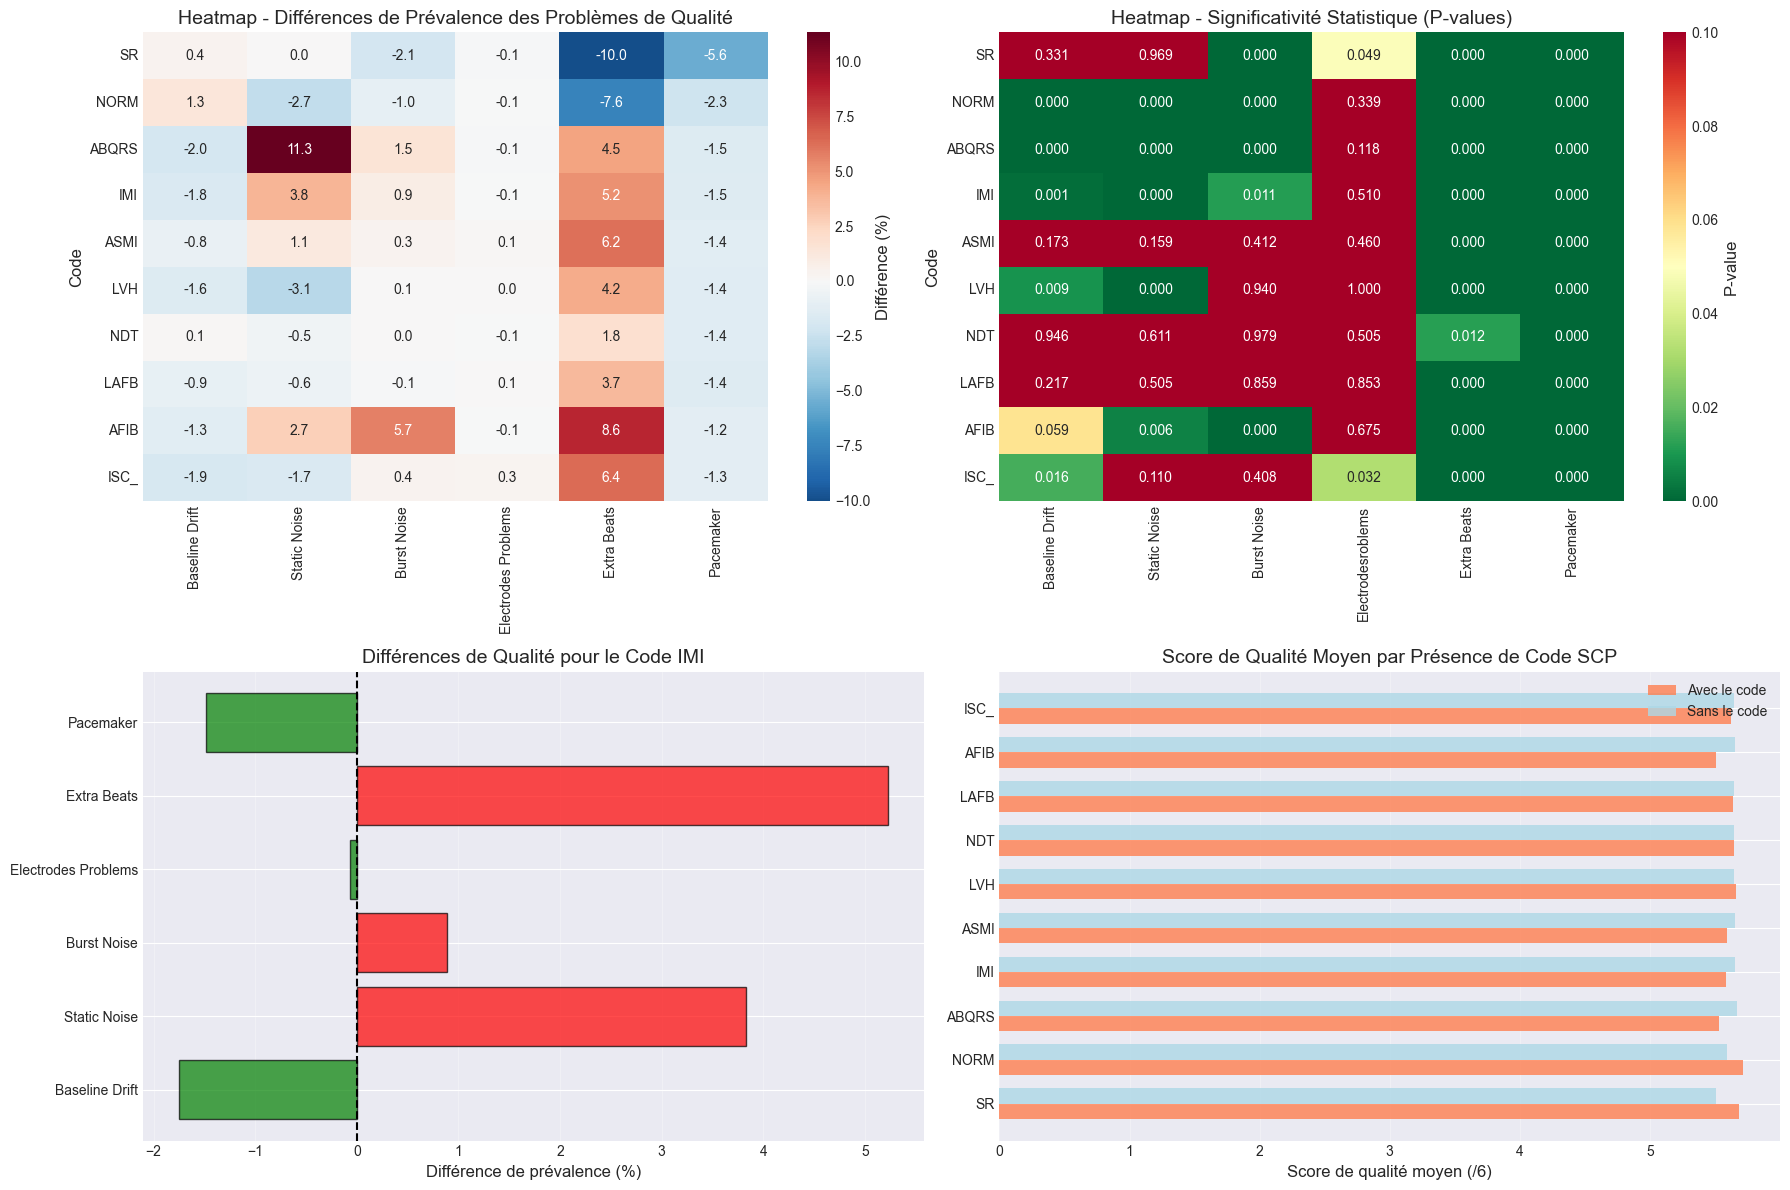

In [40]:
# ─────────────────────────────────────────────────────────────────────────────
# B.5 QUALITÉ SIGNAL vs CODES SCP (Dependances_05)
# ─────────────────────────────────────────────────────────────────────────────
print("[B.5] Génération: Dependances_05_Qualite_Codes.png...")

quality_analysis = []
for code in top_20_codes[:10]:
    result = {'Code': code}
    with_code = df_eda[df_eda[f'has_{code}'] == 1]
    without_code = df_eda[df_eda[f'has_{code}'] == 0]
    
    for qcol in quality_cols:
        prev_with = with_code[qcol].mean() * 100
        prev_without = without_code[qcol].mean() * 100
        contingency = pd.crosstab(df_eda[f'has_{code}'], df_eda[qcol])
        chi2, p, dof, exp = chi2_contingency(contingency)
        result[f'{qcol}_diff'] = prev_with - prev_without
        result[f'{qcol}_p'] = p
    
    quality_analysis.append(result)

quality_df = pd.DataFrame(quality_analysis)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. Heatmap des différences
ax1 = axes[0, 0]
diff_cols = [col for col in quality_df.columns if col.endswith('_diff')]
heatmap_data = quality_df[diff_cols].set_index(quality_df['Code'])
heatmap_data.columns = [col.replace('_diff', '').replace('_', ' ').title() for col in diff_cols]
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdBu_r', center=0, ax=ax1,
            cbar_kws={'label': 'Différence (%)'})
ax1.set_title('Heatmap - Différences de Prévalence des Problèmes de Qualité')

# 2. P-values
ax2 = axes[0, 1]
p_cols = [col for col in quality_df.columns if col.endswith('_p')]
p_data = quality_df[p_cols].set_index(quality_df['Code'])
p_data.columns = [col.replace('_p', '').replace('_', ' ').title() for col in p_cols]
sns.heatmap(p_data, annot=True, fmt='.3f', cmap='RdYlGn_r', ax=ax2,
            vmin=0, vmax=0.1, cbar_kws={'label': 'P-value'})
ax2.set_title('Heatmap - Significativité Statistique (P-values)')

# 3. Barplot pour un code spécifique
ax3 = axes[1, 0]
if 'IMI' in quality_df['Code'].values:
    imi_row = quality_df[quality_df['Code'] == 'IMI'].iloc[0]
    diff_values = [imi_row[col] for col in diff_cols]
    colors = ['red' if v > 0 else 'green' for v in diff_values]
    ax3.barh(range(len(diff_cols)), diff_values, color=colors, alpha=0.7, edgecolor='black')
    ax3.set_yticks(range(len(diff_cols)))
    ax3.set_yticklabels([col.replace('_diff', '').replace('_', ' ').title() for col in diff_cols])
    ax3.set_xlabel('Différence de prévalence (%)')
    ax3.set_title('Différences de Qualité pour le Code IMI')
    ax3.axvline(x=0, color='black', linestyle='--')
    ax3.grid(axis='x', alpha=0.3)

# 4. Score de qualité par code
ax4 = axes[1, 1]
quality_scores = []
for code in top_20_codes[:10]:
    with_code = df_eda[df_eda[f'has_{code}'] == 1]['quality_score'].mean()
    without_code = df_eda[df_eda[f'has_{code}'] == 0]['quality_score'].mean()
    quality_scores.append({'Code': code, 'Score_Avec': with_code, 'Score_Sans': without_code})

qs_df = pd.DataFrame(quality_scores)
x = np.arange(len(qs_df))
width = 0.35
ax4.barh(x - width/2, qs_df['Score_Avec'], width, label='Avec le code', color='coral', alpha=0.8)
ax4.barh(x + width/2, qs_df['Score_Sans'], width, label='Sans le code', color='lightblue', alpha=0.8)
ax4.set_yticks(x)
ax4.set_yticklabels(qs_df['Code'])
ax4.set_xlabel('Score de qualité moyen (/6)')
ax4.set_title('Score de Qualité Moyen par Présence de Code SCP')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('Dependances_05_Qualite_Codes.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: Dependances_05_Qualite_Codes.png")
plt.show()

[B.6] Génération: Dependances_06_Cooccurrences.png...
  ✓ Sauvegardé: Dependances_06_Cooccurrences.png


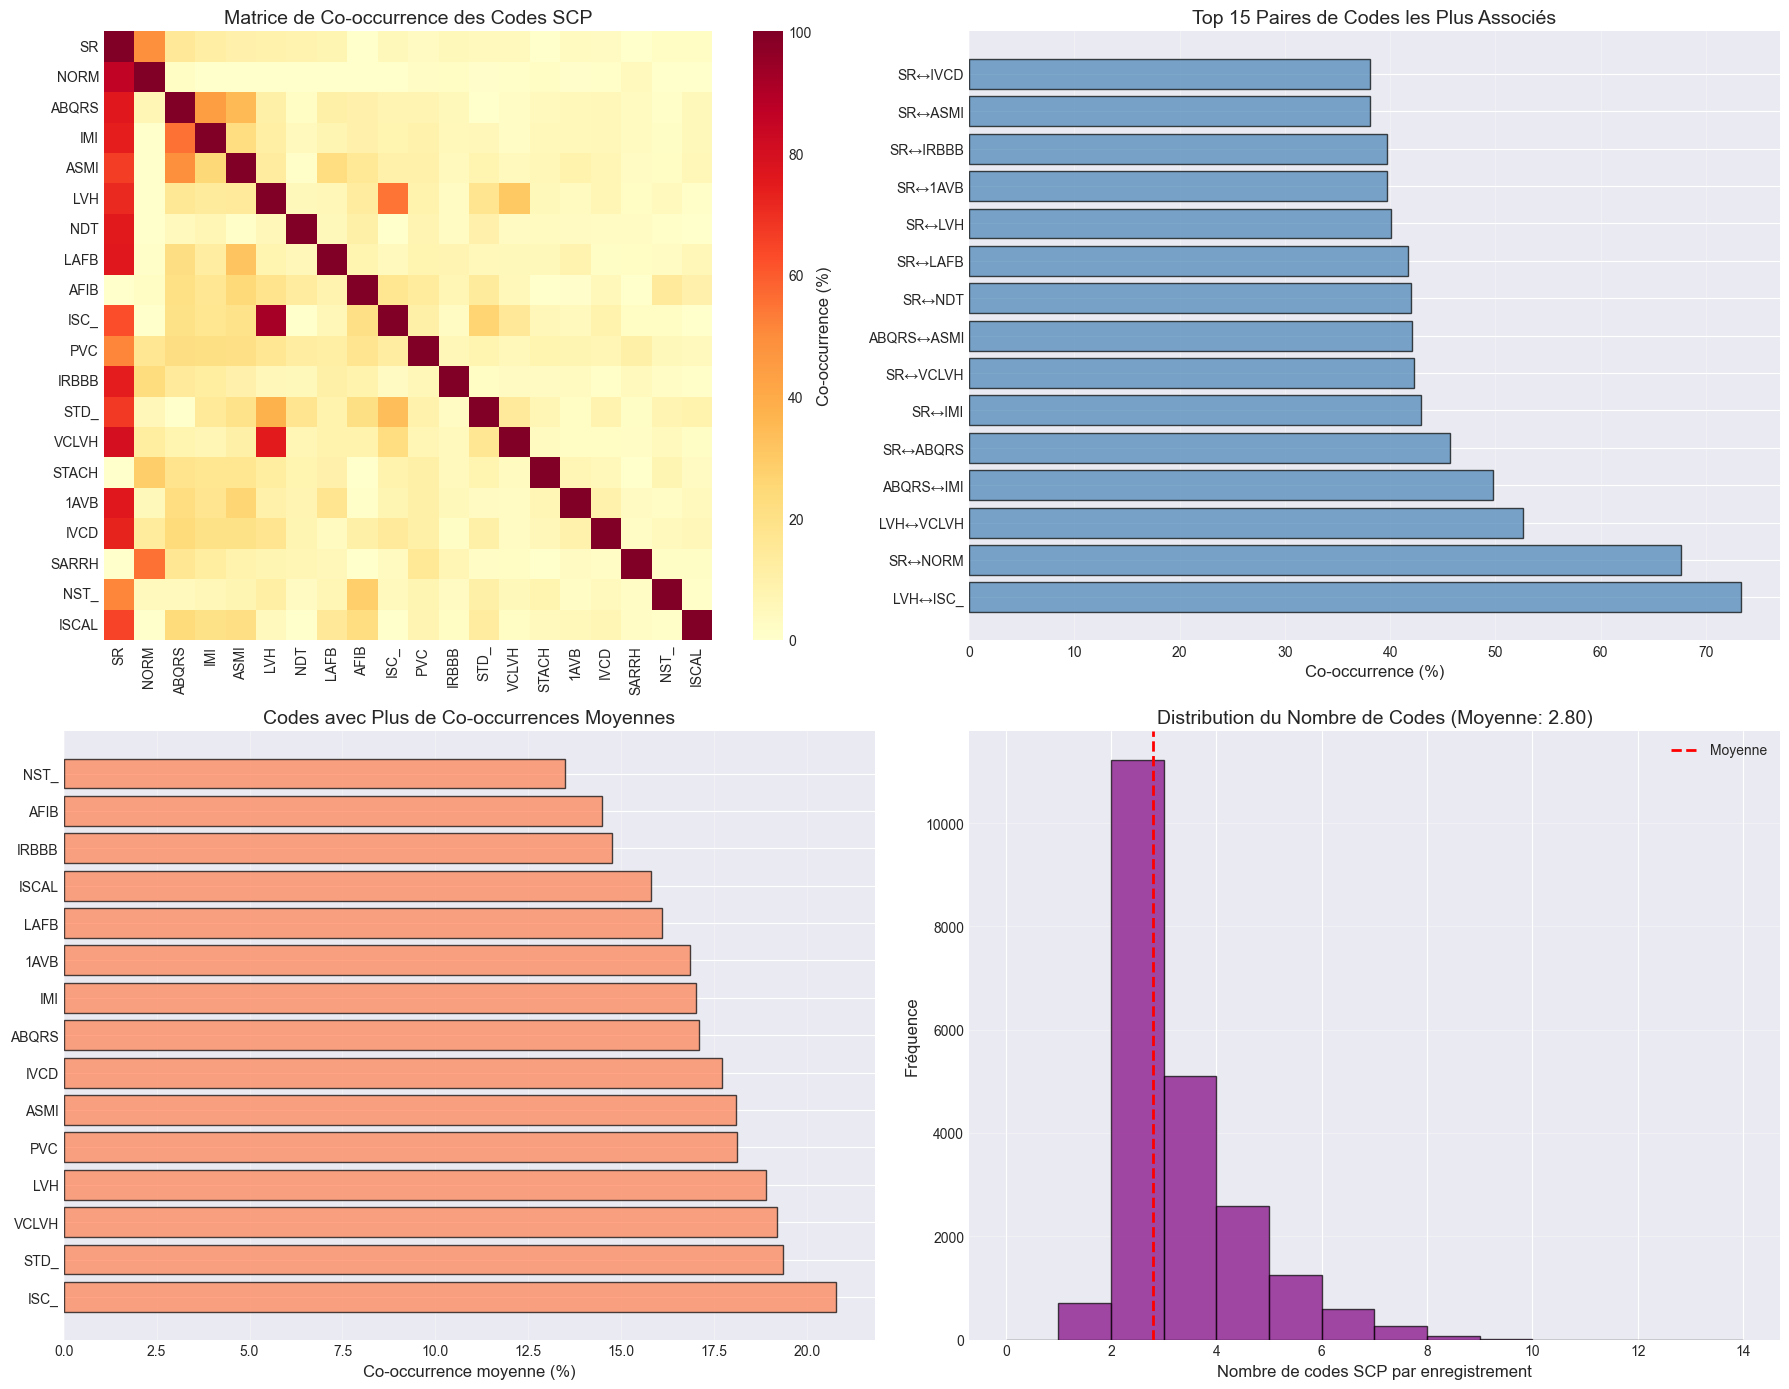

In [41]:
# ─────────────────────────────────────────────────────────────────────────────
# B.6 CO-OCCURRENCES ENTRE CODES SCP (Dependances_06)
# ─────────────────────────────────────────────────────────────────────────────
print("[B.6] Génération: Dependances_06_Cooccurrences.png...")

cooc_matrix = pd.DataFrame(0.0, index=top_20_codes, columns=top_20_codes)
for i, code1 in enumerate(top_20_codes):
    for j, code2 in enumerate(top_20_codes):
        both = ((df_eda[f'has_{code1}'] == 1) & (df_eda[f'has_{code2}'] == 1)).sum()
        total = (df_eda[f'has_{code1}'] == 1).sum()
        cooc_matrix.loc[code1, code2] = (both / total * 100) if total > 0 else 0

pairs = []
for i in range(len(top_20_codes)):
    for j in range(i+1, len(top_20_codes)):
        code1, code2 = top_20_codes[i], top_20_codes[j]
        cooc = (cooc_matrix.loc[code1, code2] + cooc_matrix.loc[code2, code1]) / 2
        pairs.append({'Code1': code1, 'Code2': code2, 'Cooccurrence': cooc})

pairs_df = pd.DataFrame(pairs).sort_values('Cooccurrence', ascending=False).head(15)

fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Heatmap co-occurrence
ax1 = axes[0, 0]
sns.heatmap(cooc_matrix.astype(float), cmap='YlOrRd', ax=ax1, 
            cbar_kws={'label': 'Co-occurrence (%)'}, square=True)
ax1.set_title('Matrice de Co-occurrence des Codes SCP')

# 2. Top paires
ax2 = axes[0, 1]
ax2.barh(range(len(pairs_df)), pairs_df['Cooccurrence'], color='steelblue', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(len(pairs_df)))
ax2.set_yticklabels([f"{row['Code1']}↔{row['Code2']}" for _, row in pairs_df.iterrows()])
ax2.set_xlabel('Co-occurrence (%)')
ax2.set_title('Top 15 Paires de Codes les Plus Associés')
ax2.grid(axis='x', alpha=0.3)

# 3. Co-occurrences moyennes
ax3 = axes[1, 0]
avg_cooc = cooc_matrix.mean(axis=1).sort_values(ascending=False).head(15)
ax3.barh(range(len(avg_cooc)), avg_cooc, color='coral', alpha=0.7, edgecolor='black')
ax3.set_yticks(range(len(avg_cooc)))
ax3.set_yticklabels(avg_cooc.index)
ax3.set_xlabel('Co-occurrence moyenne (%)')
ax3.set_title('Codes avec Plus de Co-occurrences Moyennes')
ax3.grid(axis='x', alpha=0.3)

# 4. Distribution nombre de codes
ax4 = axes[1, 1]
df_eda['num_codes'].hist(bins=range(0, 15), edgecolor='black', alpha=0.7, color='purple', ax=ax4)
ax4.set_xlabel('Nombre de codes SCP par enregistrement')
ax4.set_ylabel('Fréquence')
ax4.set_title(f'Distribution du Nombre de Codes (Moyenne: {df_eda["num_codes"].mean():.2f})')
ax4.axvline(df_eda['num_codes'].mean(), color='red', linestyle='--', linewidth=2, label='Moyenne')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('Dependances_06_Cooccurrences.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: Dependances_06_Cooccurrences.png")
plt.show()

## 🔗 PARTIE C: ANALYSE DES CORRÉLATIONS

Corrélations entre features brutes et superclasses de maladies.

[C.1] Génération: Correlation_Features_vs_Maladies.png...
  ✓ Sauvegardé: Correlation_Features_vs_Maladies.png


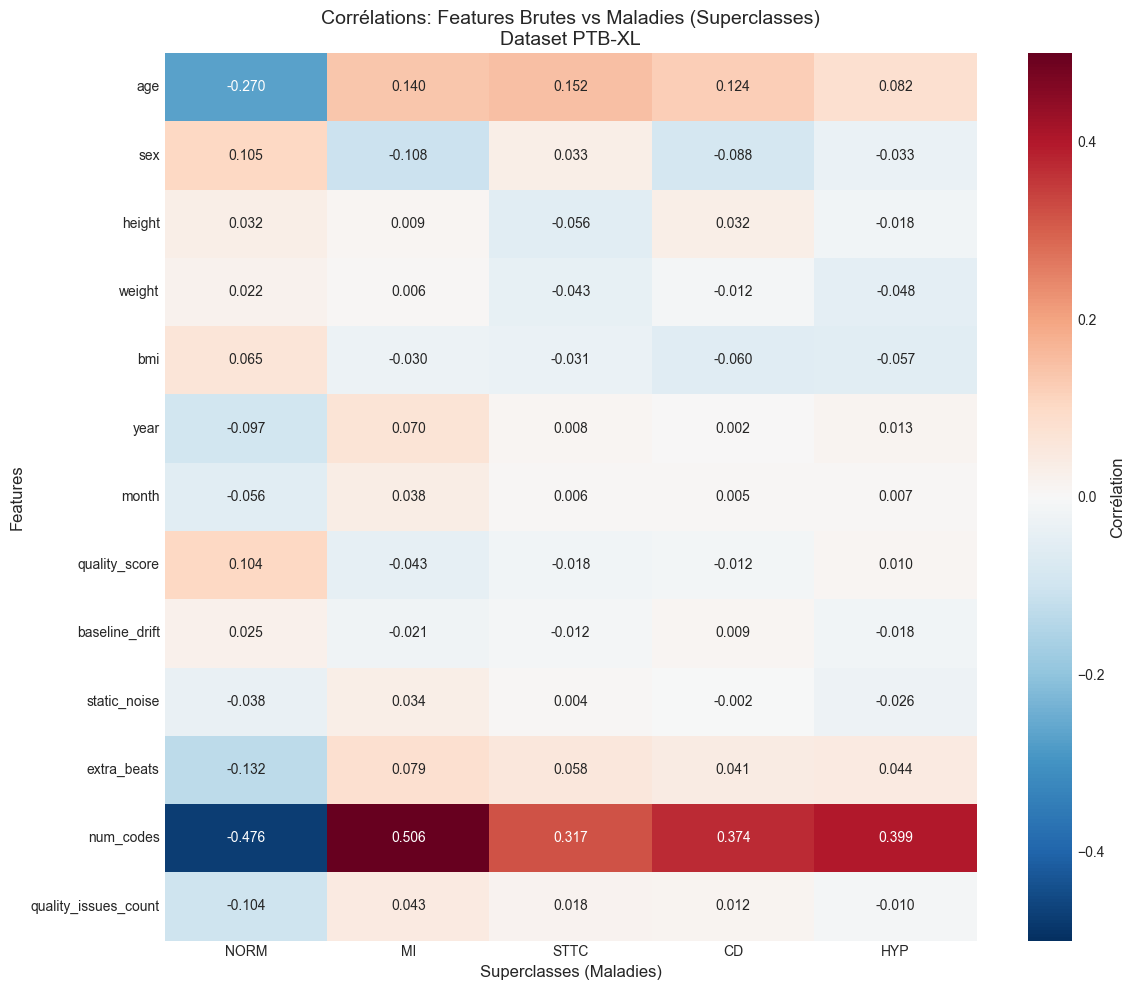

In [42]:
# ─────────────────────────────────────────────────────────────────────────────
# C.1 CORRÉLATIONS FEATURES vs MALADIES
# ─────────────────────────────────────────────────────────────────────────────
print("[C.1] Génération: Correlation_Features_vs_Maladies.png...")

# Créer labels superclasses
superclass_cols = []
for superclass in ['NORM', 'MI', 'STTC', 'CD', 'HYP']:
    col_name = f'superclass_{superclass}'
    df_eda[col_name] = 0
    for code in scp_df.index:
        if pd.notna(scp_df.loc[code, 'diagnostic_class']) and scp_df.loc[code, 'diagnostic_class'] == superclass:
            if f'has_{code}' in df_eda.columns:
                df_eda[col_name] = df_eda[col_name] | df_eda[f'has_{code}']
    superclass_cols.append(col_name)

# Features brutes à analyser
raw_features = ['age', 'sex', 'height', 'weight', 'bmi', 'year', 'month', 
                'quality_score', 'baseline_drift', 'static_noise', 'extra_beats', 'num_codes']

# Filtrer colonnes existantes
existing_features = [f for f in raw_features if f in df_eda.columns]

# Ajouter quality_issues_count si pas présent
if 'quality_issues_count' not in df_eda.columns:
    df_eda['quality_issues_count'] = df_eda[quality_cols].sum(axis=1)
    existing_features.append('quality_issues_count')

# Calculer corrélations
corr_data = {}
for superclass in superclass_cols:
    corr_data[superclass.replace('superclass_', '')] = []
    for feature in existing_features:
        if feature in df_eda.columns:
            corr = df_eda[[feature, superclass]].dropna().corr().iloc[0, 1]
            corr_data[superclass.replace('superclass_', '')].append(corr)
        else:
            corr_data[superclass.replace('superclass_', '')].append(0)

corr_df = pd.DataFrame(corr_data, index=existing_features)

# Visualisation
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='RdBu_r', center=0, ax=ax,
            cbar_kws={'label': 'Corrélation'}, vmin=-0.5, vmax=0.5)
ax.set_xlabel('Superclasses (Maladies)')
ax.set_ylabel('Features')
ax.set_title('Corrélations: Features Brutes vs Maladies (Superclasses)\nDataset PTB-XL', fontsize=14)

plt.tight_layout()
plt.savefig('Correlation_Features_vs_Maladies.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: Correlation_Features_vs_Maladies.png")
plt.show()

[C.2] Génération: Correlation_Matrix_RAW.png...
  ✓ Sauvegardé: Correlation_Matrix_RAW.png


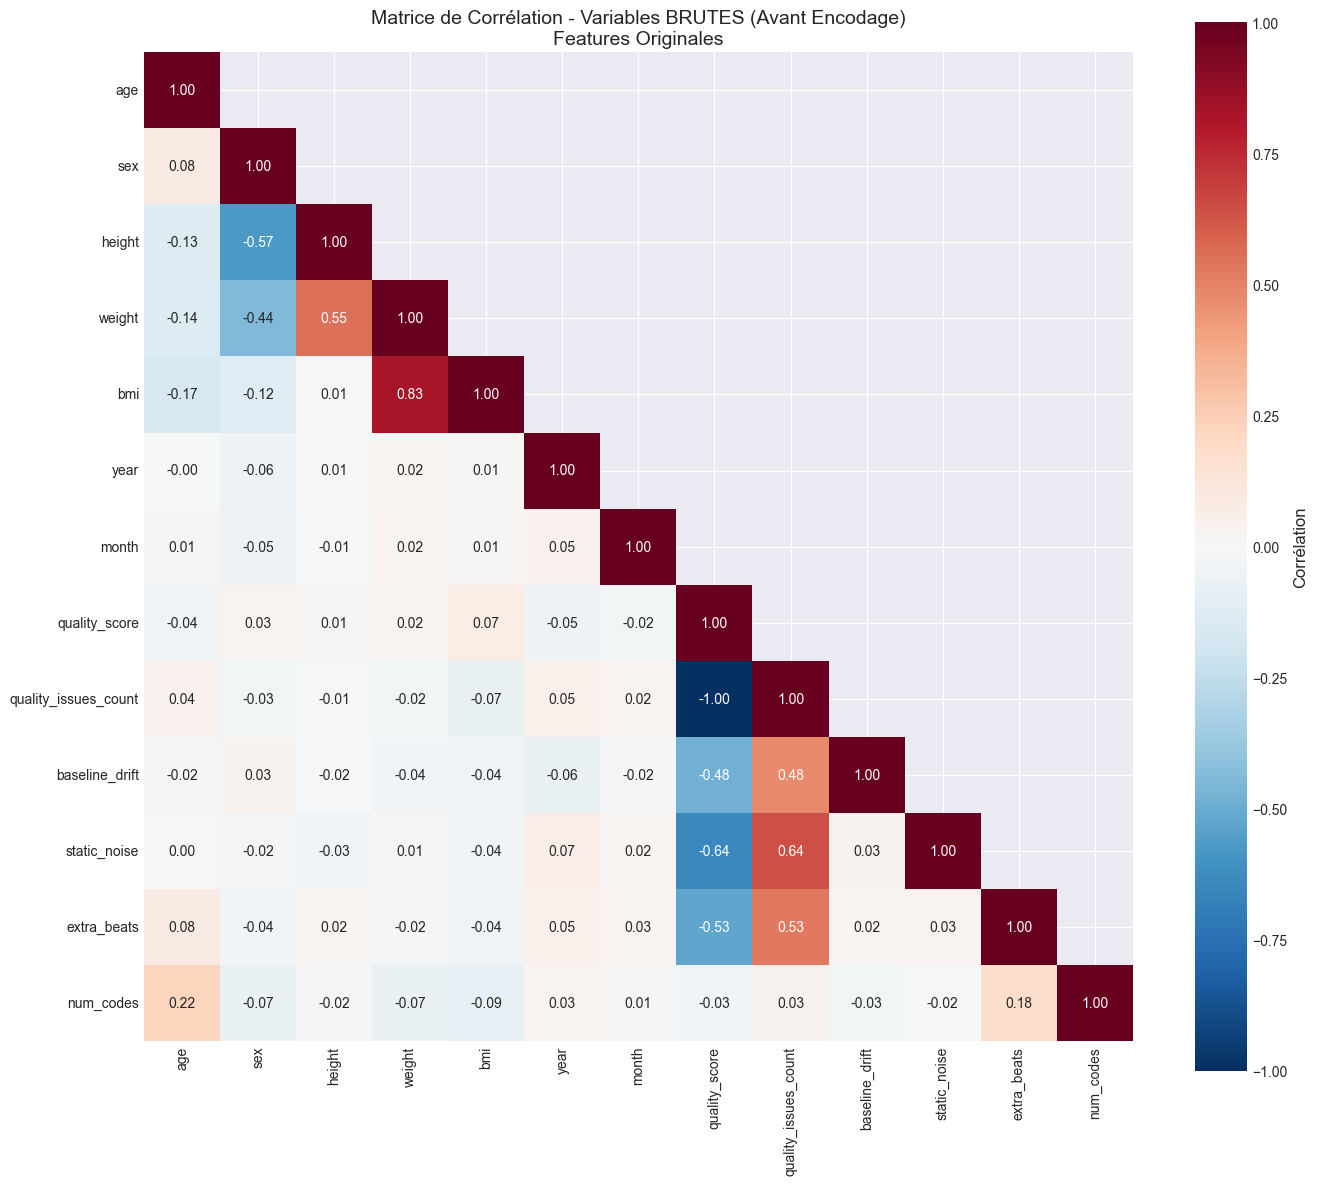

In [43]:
# ─────────────────────────────────────────────────────────────────────────────
# C.2 MATRICE DE CORRÉLATION FEATURES BRUTES
# ─────────────────────────────────────────────────────────────────────────────
print("[C.2] Génération: Correlation_Matrix_RAW.png...")

# Features numériques
numeric_features = ['age', 'sex', 'height', 'weight', 'bmi', 'year', 'month',
                    'quality_score', 'quality_issues_count', 
                    'baseline_drift', 'static_noise', 'extra_beats', 
                    'num_codes']

existing_numeric = [f for f in numeric_features if f in df_eda.columns]

corr_matrix = df_eda[existing_numeric].corr()

fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, cbar_kws={'label': 'Corrélation'},
            vmin=-1, vmax=1, square=True)
ax.set_title('Matrice de Corrélation - Variables BRUTES (Avant Encodage)\nFeatures Originales', fontsize=14)

plt.tight_layout()
plt.savefig('Correlation_Matrix_RAW.png', dpi=300, bbox_inches='tight')
print("  ✓ Sauvegardé: Correlation_Matrix_RAW.png")
plt.show()

In [44]:
# ═══════════════════════════════════════════════════════════════════════════════
# RAPPORT EDA FINAL
# ═══════════════════════════════════════════════════════════════════════════════

print()
print("═" * 100)
print("                           RAPPORT D'ANALYSE EXPLORATOIRE")
print("═" * 100)

rapport_eda = f"""
╔═══════════════════════════════════════════════════════════════════════════════════════════════════╗
║                          RAPPORT D'ANALYSE EXPLORATOIRE COMPLET                                   ║
║                               Dataset PTB-XL ECG Database v1.0.3                                  ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════════╝

Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

═══════════════════════════════════════════════════════════════════════════════════════════════════
1. STATISTIQUES GÉNÉRALES
═══════════════════════════════════════════════════════════════════════════════════════════════════

📊 Dataset
  • Nombre d'enregistrements:              {df_eda.shape[0]:>10,}
  • Nombre de patients uniques:            {df_eda['patient_id'].nunique():>10,}
  • Nombre de variables:                   {df_eda.shape[1]:>10}
  • Période:                               {df_eda['recording_date'].min().strftime('%Y-%m-%d')} à {df_eda['recording_date'].max().strftime('%Y-%m-%d')}

👥 Démographie
  • Âge moyen:                             {df_eda['age'].mean():>10.1f} ans
  • Âge médian:                            {df_eda['age'].median():>10.1f} ans
  • Femmes:                                {(df_eda['sex']==0).sum():>10,} ({(df_eda['sex']==0).sum()/len(df_eda)*100:.1f}%)
  • Hommes:                                {(df_eda['sex']==1).sum():>10,} ({(df_eda['sex']==1).sum()/len(df_eda)*100:.1f}%)

🏥 Diagnostics
  • Codes SCP uniques:                     {len(scp_counter):>10}
  • Moyenne codes/enregistrement:          {df_eda['num_codes'].mean():>10.2f}

🎯 Qualité
  • Score moyen:                           {df_eda['quality_score'].mean():>10.2f}/6

═══════════════════════════════════════════════════════════════════════════════════════════════════
2. ANALYSES DE DÉPENDANCES - RÉSUMÉ
═══════════════════════════════════════════════════════════════════════════════════════════════════

🔍 ÂGE vs CODES SCP
  • {len([a for a in age_analysis if a['Significatif'] != 'NS'])} codes sur {len(age_analysis)} montrent une association significative avec l'âge

🚻 SEXE vs CODES SCP
  • {len([s for s in sex_analysis if s['Significatif'] != 'NS'])} codes sur {len(sex_analysis)} montrent des différences significatives entre sexes

⚖️  ANTHROPOMÉTRIE vs CODES SCP
  • Associations significatives détectées pour poids, taille et IMC

📅 ÉVOLUTION TEMPORELLE
  • Tendances observées sur la période {int(df_eda['year'].min())}-{int(df_eda['year'].max())}

🔗 CO-OCCURRENCES
  • Nombre moyen de codes par patient: {df_eda['num_codes'].mean():.2f}
  • Paire la plus co-occurente: {pairs_df.iloc[0]['Code1']} ↔ {pairs_df.iloc[0]['Code2']} ({pairs_df.iloc[0]['Cooccurrence']:.1f}%)

═══════════════════════════════════════════════════════════════════════════════════════════════════
3. FICHIERS GÉNÉRÉS
═══════════════════════════════════════════════════════════════════════════════════════════════════

📊 PARTIE A: EDA GÉNÉRALE
  ✓ EDA_01_Demographics.png
  ✓ EDA_02_Diagnostics.png
  ✓ EDA_03_Temporal.png
  ✓ EDA_04_Quality.png

📈 PARTIE B: ANALYSE DES DÉPENDANCES
  ✓ Dependances_01_Age_Codes.png
  ✓ Dependances_02_Sexe_Codes.png
  ✓ Dependances_03_Anthropometrie_Codes.png
  ✓ Dependances_04_Temporel_Codes.png
  ✓ Dependances_05_Qualite_Codes.png
  ✓ Dependances_06_Cooccurrences.png

🔗 PARTIE C: CORRÉLATIONS
  ✓ Correlation_Features_vs_Maladies.png
  ✓ Correlation_Matrix_RAW.png

═══════════════════════════════════════════════════════════════════════════════════════════════════
"""

print(rapport_eda)

# Sauvegarder le rapport
with open('EDA_Rapport_Complet.txt', 'w', encoding='utf-8') as f:
    f.write(rapport_eda)

print("✓ Rapport sauvegardé: EDA_Rapport_Complet.txt")

print()
print("█" * 100)
print("█" + " " * 98 + "█")
print("█" + "  ✅ ANALYSE EXPLORATOIRE COMPLÈTE TERMINÉE AVEC SUCCÈS".center(98) + "█")
print("█" + " " * 98 + "█")
print("█" + f"  Total: 12 graphiques + 1 rapport générés".center(98) + "█")
print("█" + " " * 98 + "█")
print("█" * 100)


════════════════════════════════════════════════════════════════════════════════════════════════════
                           RAPPORT D'ANALYSE EXPLORATOIRE
════════════════════════════════════════════════════════════════════════════════════════════════════

╔═══════════════════════════════════════════════════════════════════════════════════════════════════╗
║                          RAPPORT D'ANALYSE EXPLORATOIRE COMPLET                                   ║
║                               Dataset PTB-XL ECG Database v1.0.3                                  ║
╚═══════════════════════════════════════════════════════════════════════════════════════════════════╝

Date: 2026-01-18 17:54:52

═══════════════════════════════════════════════════════════════════════════════════════════════════
1. STATISTIQUES GÉNÉRALES
═══════════════════════════════════════════════════════════════════════════════════════════════════

📊 Dataset
  • Nombre d'enregistrements:                  21,799
  • Nombre 

---

# 🔚 FIN DE L'EDA - DÉBUT DU PIPELINE ML

L'analyse exploratoire est terminée. Les sections suivantes contiennent le pipeline de Machine Learning Wide+Deep.

---

# 1️⃣ Configuration & Imports

In [45]:
"""
═══════════════════════════════════════════════════════════════════════════════
CONFIGURATION ET IMPORTS
═══════════════════════════════════════════════════════════════════════════════
"""

# ===== Standard Libraries =====
import os
import sys
import ast
import json
import warnings
from pathlib import Path
from datetime import datetime
from collections import Counter
from tqdm import tqdm

# ===== IMPORTANT: Changer vers le répertoire contenant les données =====
# Le notebook est dans le dossier parent, mais les données sont dans le sous-dossier
DATA_DIR = Path(r"c:\Users\HATIM\Desktop\projet analytics\Nouveau dossier (2)\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3 - Copie\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3")
os.chdir(DATA_DIR)
print(f"📁 Répertoire de travail: {os.getcwd()}")

# ===== Data Processing =====
import numpy as np
import pandas as pd

# ===== Machine Learning - Sklearn =====
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report

# ===== Deep Learning - PyTorch =====
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math

# ===== Signal Processing =====
import wfdb
import neurokit2 as nk

# ===== Visualization =====
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Settings =====
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# ===== Device Configuration =====
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"PyTorch version: {torch.__version__}")
print(f"Device: {DEVICE}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# ===== Global Configuration =====
CONFIG = {
    'BATCH_SIZE': 32,
    'LEARNING_RATE': 1e-4,
    'WEIGHT_DECAY': 1e-4,
    'EPOCHS': 50,
    'PATIENCE': 10,
    'NUM_CLASSES': 5,
    'SAMPLING_RATE': 100,
    'SIGNAL_LENGTH': 1000,
    'N_LEADS': 12,
    'WIDE_DIM': 32,
}

CLASS_NAMES = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
CLASS_COLORS = ['#27ae60', '#e74c3c', '#3498db', '#9b59b6', '#f39c12']

print("\n✅ Configuration chargée!")
print(f"  • Batch size: {CONFIG['BATCH_SIZE']}")
print(f"  • Learning rate: {CONFIG['LEARNING_RATE']}")
print(f"  • Classes: {CLASS_NAMES}")

📁 Répertoire de travail: c:\Users\HATIM\Desktop\projet analytics\Nouveau dossier (2)\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3 - Copie\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3
PyTorch version: 2.5.1+cu121
Device: cuda
GPU: NVIDIA GeForce RTX 3060 Laptop GPU

✅ Configuration chargée!
  • Batch size: 32
  • Learning rate: 0.0001
  • Classes: ['NORM', 'MI', 'STTC', 'CD', 'HYP']
